# Visualising a Convolutional Neural Network

This is my first time playing with convolutional neural networks, tensorflow and keras, and the beauty of these packages is how quickly you can produce a network that gives very good results, especially on something like the MNIST dataset. However, they hide almost all the details of what they're doing in the background, and I wanted to get an idea of what's really happening behind the scenes.

I spent quite some time trying different approaches to look in to what the networks I created were doing, and the few I thought were most useful are shown in this notebook. The main three are plotting the confusion matrix, visualising the network's ability to separate image classes after each layer using TSNE, and showing how the representation of the image changes after each network layer. As a spoiler, here's an example of the type of plots that are produced (the details are explained later in the notebook):

![Image](https://i.imgur.com/l3kzqZU.png)

The notebook starts with the [class I have written](#classcode) with various functions to visualise what's happening in the network. However, it has several hundred lines of code and to begin with I'd suggest you jump straight to [where I begin putting the class in action](#simplenetwork). For me the aim of this notebook is to understand the networks, rather than the details of the code or the accuracy they achieve.

If you do want to look at the class code I have added a lot of documentation/comments to it, so hopefully it's understandable. I've also tried to make the class flexible enough to work with different networks, or even different datasets (though I haven't tested that - in particular it's likely non-numeric classes would give errors). It would be great if people fork the notebook and use the class themselves. Even better if you publicly post what you've done with it and let me know so I can have a look! Also, if you have suggestions for things I could add I'd be interested to hear about those too.

**Sections of this notebook:**
* [Modules I have used](#modules)
* [NetworkVisualiser Class](#classcode)
* [Visualising a simple network with one dense layer](#simplenetwork)
* [Visualising a network with one convolutional layer](#oneconvol)
* [Visualising a network with multiple convolutional layers](#multiconvol)

**Links that may be useful:**
* [Kaggle Deep Learning Track](https://www.kaggle.com/learn/deep-learning): The neural networks I define generally use the same packages and have the same type of infrastructure from these courses, and these work very well on the MNIST dataset.
* [A Guide to TF Layers: Building a Convolutional Neural Network](https://www.tensorflow.org/tutorials/layers): A guide in the TensorFlow documentation using the MNIST data. It doesn't use keras as I do here, but it gave me some ideas about combinations of layers I could try, including MaxPool2D layers.
* [Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6) by [Yassine Ghouzam](https://www.kaggle.com/yassineghouzam): An excellent and popular kernel that shows how you can get very high accuracies using similar networks to the ones I define here, with a few extra tips and tricks to improve the results.
* [sklearn documentation on manifold learning](http://scikit-learn.org/stable/modules/manifold.html), which includes the TSNE technique I use here.
* [sklearn documentation on component analysis](http://scikit-learn.org/stable/modules/decomposition.html).

<a id='modules'></a>
## Module Imports

In [1]:
# general data and misc libraries
import pandas as pd
import numpy as np
from math import ceil

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# tensorflow/keras for cnn training
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

# sklearn component analysis and utilities
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

<a id='classcode'></a>
## NetworkVisualiser class

In [2]:
class NetworkVisualiser:
    '''Utility to visualise the progression of an image through the layers of a convolutional neural network. 
    Networks are created with tensorflow.python.keras.
    
    layers: A list of tensorflow.python.keras.layers from which the neural network is created.
    The layers are added to a Sequential model, and the last (output) layer should be a Dense layer
    with num_classes nodes. It is highly recommended to set the name parameter of each layer
    to a short meaningful value to aid the interpretation of the visualisations created.
    
    data_file: Path to file containing image data. Each image must be represented by a flattened
    row of pixel values in the file.
        
    label_col: Column in data_file to use for image class labels.
    
    num_classes: Number of different image classes contained in the data.
    
    img_rows: Height of each image in pixels.
    
    img_cols: Width of each image in pixels.'''
    
    def __init__(self, layers, data_file='train.csv',label_col='label',
                 num_classes=10,img_rows=28,img_cols=28):
        
        # definition of network infrastructure
        self.layers = layers
        # no. layers in defined network
        self.n_layers = len(layers)

        # no. of classes to identify in images
        self.num_classes = num_classes
        # height of images in pixels 
        self.img_rows = img_rows
        # width of images in pixels
        self.img_cols = img_cols
        
        # load data file
        self.load_data(data_file, label_col)
                
    def load_data(self, data_file, label_col):
        '''Load data from file, separate images and class labels,
        reshape the images, and create class vectors. Called automatically
        during class initialisation.
        
        data_file: Path to file containing image data. Each image must be
        represented by a flattened row of pixel values in the file.
        
        label_col: Data column to use for image class labels.'''
        
        print('Loading data...')
        df = pd.read_csv(data_file)
        print('Shape of data file:',df.shape)

        # get data excluding label column
        X = df.drop(label_col,axis=1)
       
        # reconstruct images from flattened rows
        X = X.values.reshape(len(X),self.img_rows,self.img_cols,1)
        
        # normalise X to lie between 0 and 1
        X = X/X.max()
       
        self.X = X
        print('Shape of network input:',X.shape)

        # extract true label of each image
        self.labels = df[label_col].values
        
        # convert labels in to dummy vectors
        y = keras.utils.to_categorical(self.labels, self.num_classes)
        self.y = y
        print('Shape of label vectors:',y.shape)
        print('First label vector:',y[0])
        
    def show_images(self, images_per_class=10):
        '''Display example images from each class.
        
        images_per_class: defines how many images will be displayed
        for each class.'''
        plt.figure(figsize=(images_per_class,self.num_classes))

        for i in range(self.num_classes):
            # select images in class i
            tmp = self.X[self.y[:,i]==1]

            # display 1st 10 images in class i
            for j in range(10):
                plt.subplot(self.num_classes,10,(10*i)+(j+1))
                plt.imshow(tmp[j][:,:,0])

                # use the same colour range for each image
                plt.clim(0,1)
                # don't show axes
                plt.axis('off')
                
    def fit(self,
            loss=keras.losses.categorical_crossentropy,
            optimizer='adam', metrics=['accuracy'],
            epochs=3, batch_size=100, validation_split=0.2):
        '''Creates a network using the layers defined in self.layers,
        fits the network, and then calls self.set_layer_outputs.
        
        Arguments are passed to tensorflow.python.keras.models.Sequential.compile
        and tensorflow.python.keras.models.Sequential.fit.'''
        
        # Buld model
        self.model = Sequential()

        # add each defined layer to the model
        for layer in self.layers:
            self.model.add(layer)
            
        # get layer names
        self.layer_names = [self.model.layers[i].name for i in range(self.n_layers)]

        # set model optimisation parameters
        self.model.compile(loss=loss,optimizer=optimizer,
                           metrics=metrics)

        # Fit model
        self.model.fit(self.X, self.y,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split = validation_split)
        
        # calculate output at each network layer
        self.set_layer_outputs()

    def set_layer_outputs(self): 
        '''Calculates the representation of each image in each layer of the network.'''
        
        print('Calculating output at each layer...')
        # maximum no. filters in any convolutional layer, used to define figure sizes later
        # initialise at 9 (min fig size), overwrite in loop if a layer has more than 9
        self.max_filters = 9

        self.layer_out = []
        prev_layer_out = None

        for key in self.layer_names:
            # create a model consisting of only the current layer
            layer_model = Sequential()
            layer_model.add(self.model.get_layer(key))

            # if this is the first layer, predict using the input images
            if prev_layer_out is None:
                curr_layer_out = layer_model.predict(self.X)
                #self.layer_out.append(layer_model.predict(self.X))
            # otherwise, predict using output of previous layer
            else:
                curr_layer_out = layer_model.predict(prev_layer_out)

            self.layer_out.append(curr_layer_out)
            
            # check if this is a convolution layer with more filters
            # than the current maximum.
            if curr_layer_out.ndim==4:
                n_filters = curr_layer_out.shape[-1]
                if n_filters>self.max_filters:
                    self.max_filters = n_filters

            prev_layer_out = curr_layer_out

            print(key, 'layer has shape',curr_layer_out.shape)
            
        # probability network assigns to correct label for each image
        # (self.layer_out[-1] is output layer)
        self.true_prob = pd.Series([self.layer_out[-1][i,self.labels[i]] for i in range(len(self.labels))])

        
    def show_conf_matrix(self):
        '''Calculate and display the network confusion matrix.'''
        # calculate confusion matrix
        cm=confusion_matrix(self.labels,
                            self.layer_out[-1].argmax(axis=1))

        # convert to percentages
        cm=100*cm/cm.sum(axis=1)

        # display
        plt.figure(figsize=(10,8))
        sns.heatmap(cm,annot=True,square=True,cmap=plt.rcParams['image.cmap'],fmt='.1f',
                    vmax=2*max([np.triu(cm,k=1).max(),np.tril(cm,k=-1).max()]))
        # vmax: used to limit range of colour bar to highlight incorrect predictions,
        # rather than letting diagonal dominate. Current limit is double the maximum
        # incorrect prediction prediction for any number (2*max in upper or lower triangle).
        plt.ylabel('TRUE')
        plt.xlabel('PREDICTED')
        
    def tsne_layers(self,img_ids):
        '''Use sklearn.manifold.TSNE to produce a 2D representation of the segmentation
        of image classes in each layer of the network. 
        
        As TSNE is computationally expensive and impractical to use for internal layers
        that may have thousands of features, the top self.num_classes components in the
        output of each layer are first extracted using sklearn.decomposition import PCA.
        TSNE is then run on the PCA components.
        
        img_ids: Indices of images to use to calculate and display the TSNE results.
        Strongly recommended not to use all images, which will likely fail to compute
        and in any case would produce messy plots. Choosing ~1000 images typically
        gives good results.'''
        
        # t-sne to see distinction between digits at different layers
        print('Calculating TSNE representations...')
        # TSNE too computationally expensive to run on data with many features.
        # First use PCA to extract the first num_classes components, then follow with TSNE.
        pipe = Pipeline([('pca',PCA(n_components=self.num_classes)),('tsne',TSNE())])

        # make figure
        rows = ceil(np.sqrt(self.n_layers+1))
        cols = ceil((self.n_layers+1)/rows)
        plt.figure(figsize=(5*cols,4*rows))

        # visualise structure of input 
        i=1
        print('Input...',end='')
        # flatten data
        pipe_in = self.X[img_ids].reshape([len(img_ids),-1])
        # transform data
        pipe_out = pipe.fit_transform(pipe_in)
        # plot data, with points coloured by class
        plt.subplot(rows,cols,i)
        plt.scatter(pipe_out[:,0],pipe_out[:,1],c=self.labels[img_ids],cmap='tab10',s=2)
        plt.xticks([]), plt.yticks([])
        plt.colorbar()
        plt.title('Input')
        i+=1

        # visualise structure of network layers
        for id_layer in range(self.n_layers):
            key = self.layer_names[id_layer]
            out = self.layer_out[id_layer]
            print(key+'...',end='')
            
            pipe_in = out[img_ids].reshape([len(img_ids),-1])
            pipe_out = pipe.fit_transform(pipe_in)

            plt.subplot(rows,cols,i)
            plt.scatter(pipe_out[:,0],pipe_out[:,1],c=self.labels[img_ids],cmap='tab10',s=2)
            plt.xticks([]), plt.yticks([])
            plt.colorbar()
            plt.title(key)
            i+=1
        print('Done!')
        
    def visualise_network(self,img_id):
        '''Visualise one image in all layers of the neural network.
        
        img_id: The index of the image to be displayed.'''
        
        # no. rows in figure (including extra row for input layer)
        nrows = self.n_layers+1
        # no. additional columns for text labels
        txtwidth = max([int(self.max_filters/12),2])
        ncols = self.max_filters+txtwidth
        # text box/font style
        props = dict(boxstyle='round', facecolor='w')
        fontsize = 1.3*ncols
        # create figure
        plt.figure(figsize=(2*ncols,2*nrows))

        ####################
        # input
        ####################

        # title
        row = 1
        ax = plt.subplot2grid((nrows, ncols), (0, 0), colspan=txtwidth)
        plt.plot([0,0],[1,1])
        ax.text(0, 1, 'Input', verticalalignment='center',fontsize=fontsize,bbox=props)
        plt.axis('off')

        # show input image
        plt.subplot2grid((nrows, ncols), (0, int((ncols-txtwidth)/2 + 0.5*txtwidth)), colspan=txtwidth)
        plt.imshow(self.X[img_id][:,:,0])
        plt.clim(0,1)
        plt.axis('off')

        # true label of input image
        ax = plt.subplot2grid((nrows, ncols), (0, txtwidth), colspan=txtwidth)
        plt.plot([0,0],[1,1])
        ax.text(0,1,
                'True label: '+str(self.y[img_id,:].argmax()),
                verticalalignment='center',horizontalalignment='center',fontsize=fontsize,bbox=props)
        plt.axis('off')

        # predicted label for input image
        ax = plt.subplot2grid((nrows, ncols), (0, ncols-txtwidth-1), colspan=txtwidth)
        plt.plot([0,0],[1,1])
        ax.text(0,1,
                'Predicted: '+
                str(self.layer_out[-1][img_id,:].argmax())+
                ' ({:.1f}% probability)'.format(100*self.layer_out[-1][img_id,:].max()),
                verticalalignment='center',horizontalalignment='center',
                fontsize=fontsize,bbox=props)
        plt.axis('off')

        #######################
        # remaining layers
        #######################

        for id_layer in range(self.n_layers):
            key = self.layer_names[id_layer]
            out = self.layer_out[id_layer]

            row += 1

            # layer title
            ax = plt.subplot2grid((nrows, ncols), (row-1, 0), colspan=txtwidth)
            plt.plot([0,0],[1,1])
            ax.text(0, 1, key, verticalalignment='center',fontsize=fontsize,bbox=props)
            plt.axis('off')

            # annotated heatmap for output layer
            if id_layer is self.n_layers-1:
                plt.subplot2grid((nrows, ncols), (row-1, txtwidth), colspan=ncols-txtwidth)
                sns.heatmap(out[img_id,:].reshape([1,-1])*100,
                            annot=True,annot_kws={"size": fontsize},fmt='.1f',
                            cmap=plt.rcParams['image.cmap'],cbar=False)
                plt.yticks([])
                plt.xticks(fontsize=fontsize)

            # plot image representation for convolutional layers (4 dimensions: image, row, column, filter)
            elif out.ndim==4:
                # no. filters in layer
                n_filters = out.shape[-1]
                # no. subplots each filter spans in this layer
                nsub_per_filt = self.max_filters/n_filters
                # plot each filter
                for i in range(n_filters):
                    plt.subplot2grid((nrows, ncols), (row-1, txtwidth+int(i*nsub_per_filt)), colspan=int(nsub_per_filt))
                    plt.imshow(out[img_id,:,:,i])
                    plt.axis('off')

            # 1d image plot for flattened layers (e.g. dense)
            else:
                n_filters = out.shape[-1]

                plt.subplot2grid((nrows, ncols), (row-1, txtwidth), colspan=ncols-txtwidth)
                plt.imshow(out[img_id,:].reshape(1,n_filters),aspect=max([n_filters/20,1]))
                plt.axis('off')

    def visualise_classbest(self):
        '''Visualise the image in each class that the network predicts most accurately,
        i.e. the image assigned the highest probability matching the true image label in each class.'''
        
        for i in range(self.num_classes):
            self.visualise_network(self.true_prob[self.labels==i].sort_values(ascending=False).index[0])   

            
    def visualise_classworst(self):
        '''Visualise the image in each class that the network predicts least accurately,
        i.e. the image assigned the lowest probability matching the true image label in each class.'''
        
        for i in range(self.num_classes):
            self.visualise_network(self.true_prob[self.labels==i].sort_values().index[0])   

    def visualise_best(self, n_plots=5):
        '''Visualise the images that are most accurately predicted by the model
        (irrespective of class), i.e. the images with the largest probability
        assigned to the true image label.
        
        n_plots: Number of images to visualise.'''
        wrong_pred = self.true_prob.sort_values(ascending=False).index[:n_plots]

        for img_id in wrong_pred:
            self.visualise_network(img_id)

            
    def visualise_worst(self,n_plots=5):
        '''Visualise the images that are least accurately predicted by the model
        (irrespective of class), i.e. the images with the lowest probability
        assigned to the true image label.
        
        n_plots: Number of images to visualise.'''
        
        wrong_pred = self.true_prob.sort_values().index[:n_plots]

        for img_id in wrong_pred:
            self.visualise_network(img_id)

    def visualise_unsure(self,n_plots=5):
        '''Visualise the images that the network is least confident about which
        class the image should be assigned to, i.e. the images which have the
        smallest probabilities assigned to the predicted labels.
        
        n_plots: Number of images to visualise.'''

        # visualise predictions network is least sure about - smallest max probability
        worst_pred = self.layer_out[-1].max(axis=1).argsort()[:n_plots]

        for img_id in worst_pred:
            self.visualise_network(img_id)

<a id='simplenetwork'></a>
## The Simplest Possible Network

In [3]:
data_file='train.csv'
label_col='label'
num_classes=10
img_rows=28
img_cols=28

# set default colour map to use
plt.rcParams['image.cmap'] = 'Reds'

Loading data...
Shape of data file: (42000, 785)
Shape of network input: (42000, 28, 28, 1)
Shape of label vectors: (42000, 10)
First label vector: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


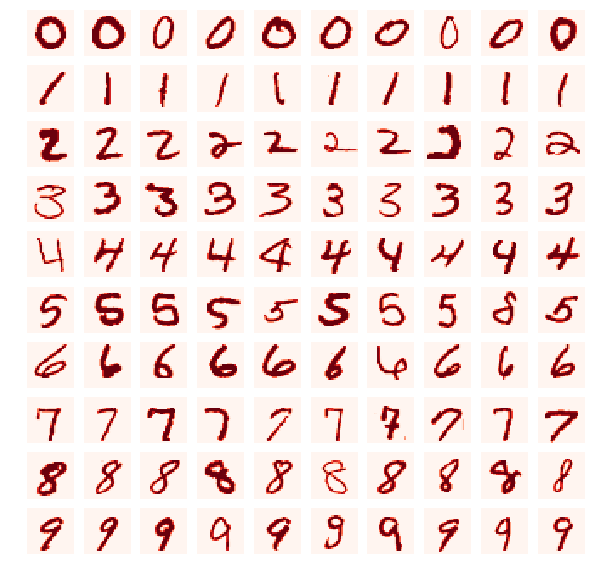

In [4]:
layers = [
          Flatten(name='Flatten'),
          Dense(num_classes, activation='softmax',
                          name='Output')
        ]

nvis = NetworkVisualiser(layers)

nvis.show_images()

Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 2s 57us/step - loss: 0.7850 - acc: 0.8039 - val_loss: 0.4517 - val_acc: 0.8837
Epoch 2/3
33600/33600 [==============================] - 2s 50us/step - loss: 0.4014 - acc: 0.8936 - val_loss: 0.3610 - val_acc: 0.9038
Epoch 3/3
33600/33600 [==============================] - 2s 51us/step - loss: 0.3430 - acc: 0.9059 - val_loss: 0.3282 - val_acc: 0.9117
Calculating output at each layer...
Flatten layer has shape (42000, 784)
Output layer has shape (42000, 10)


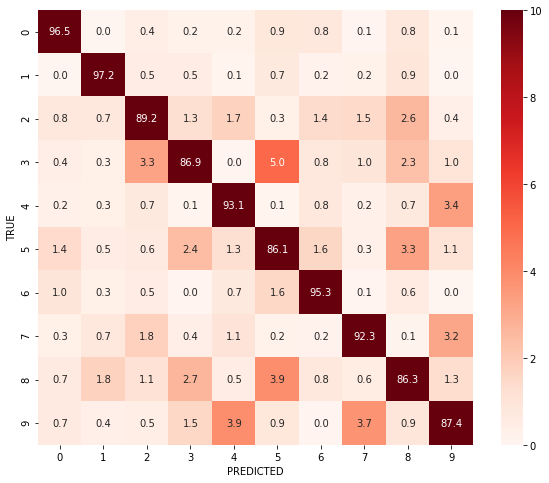

In [5]:
nvis.fit(epochs=3)
nvis.show_conf_matrix()

Calculating TSNE representations...
Input...Flatten...Output...Done!


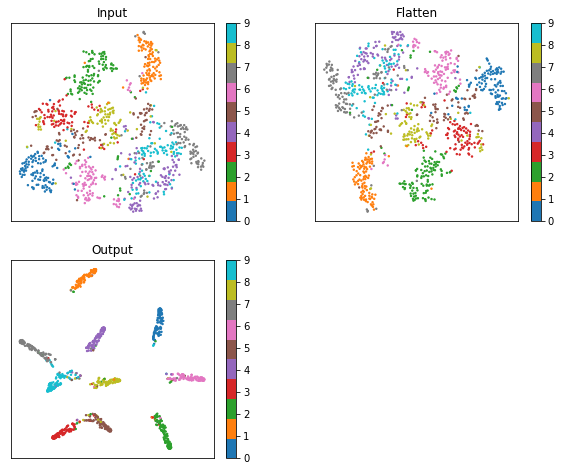

In [6]:
nvis.tsne_layers(range(1000))

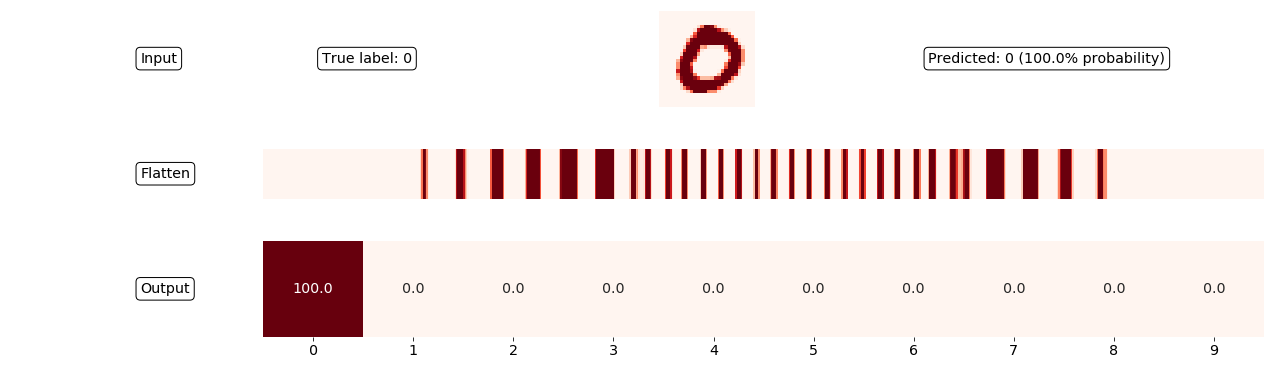

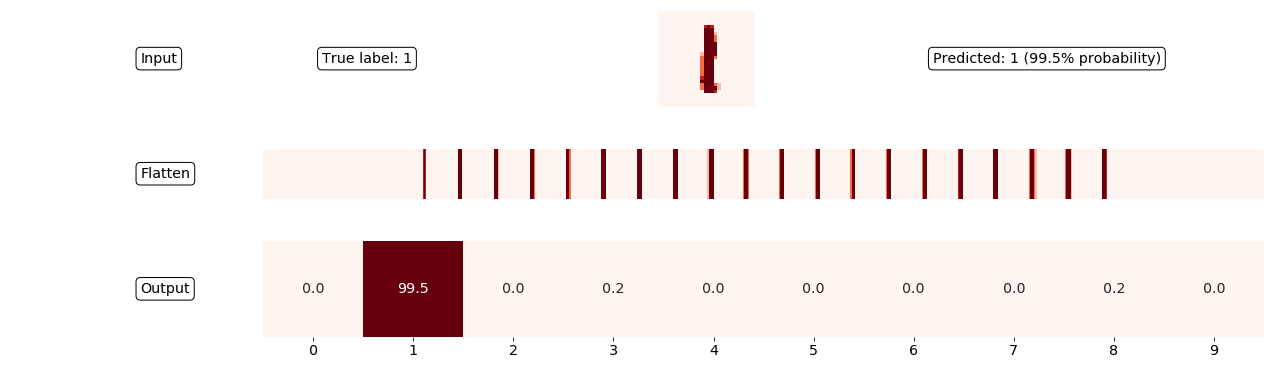

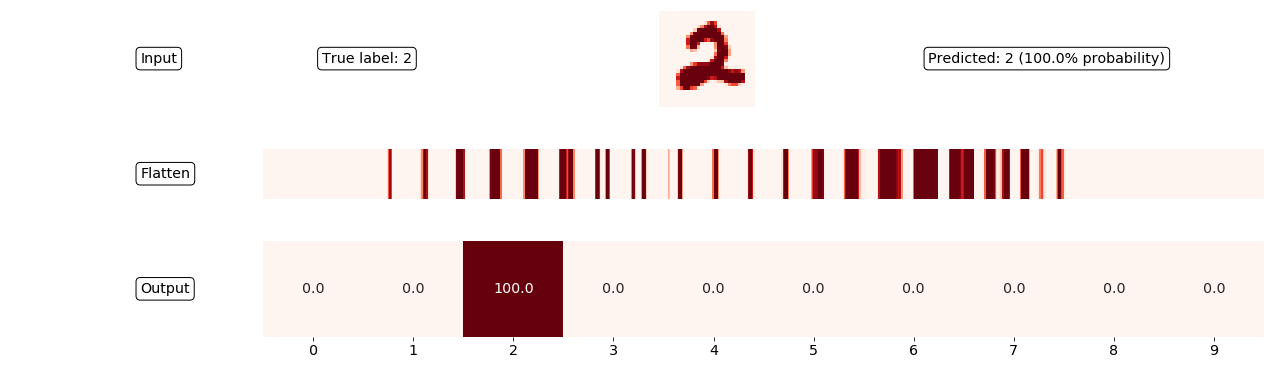

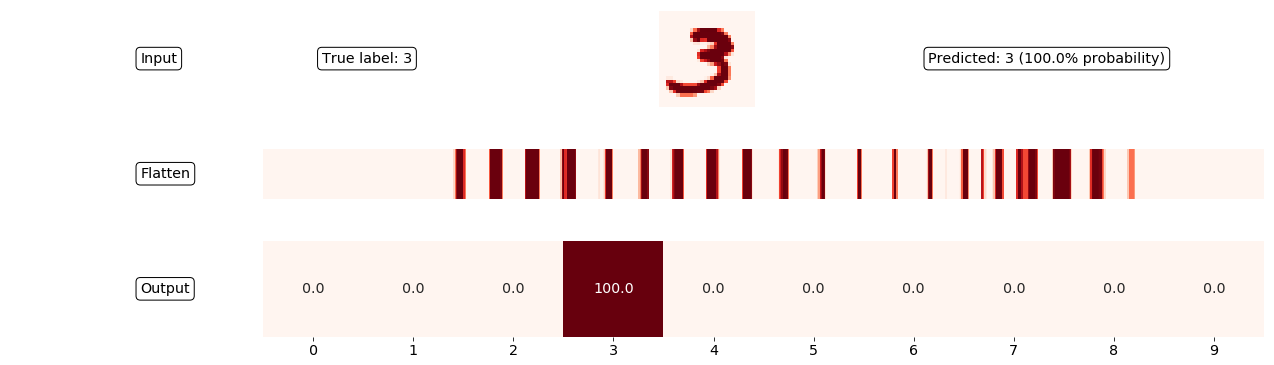

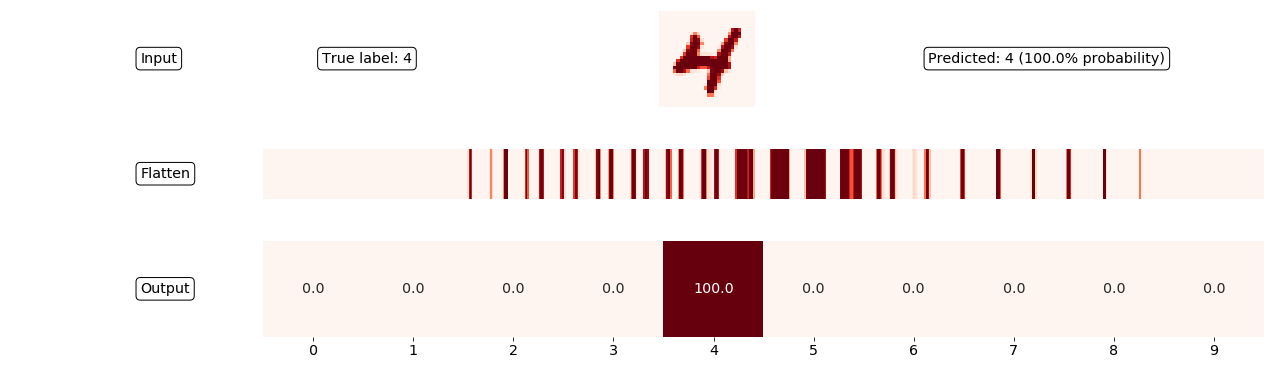

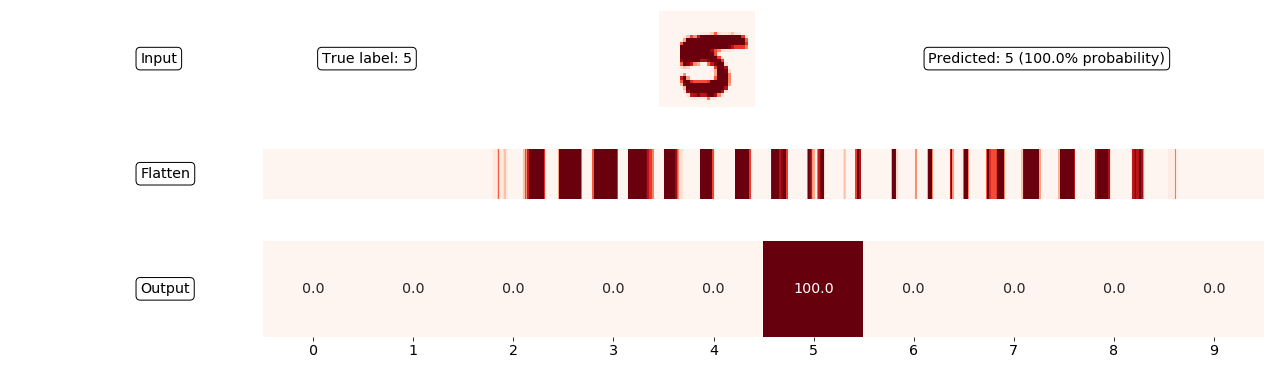

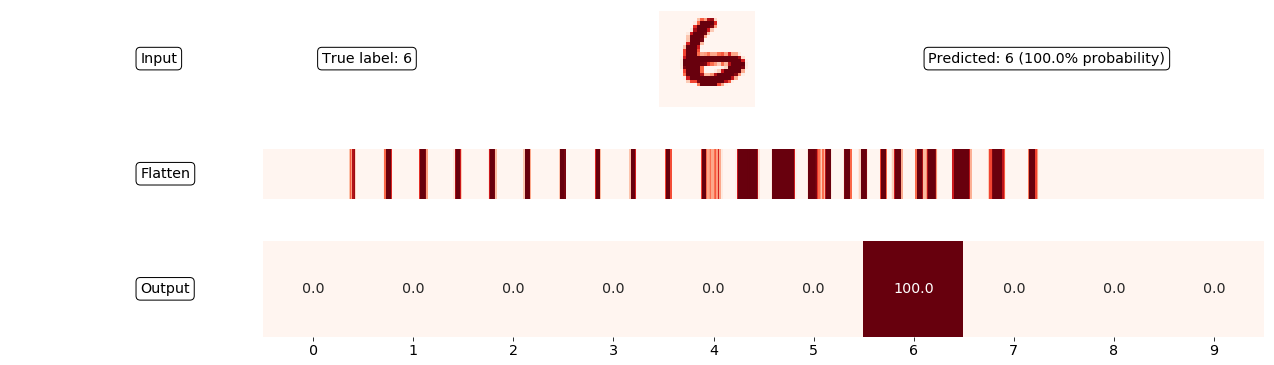

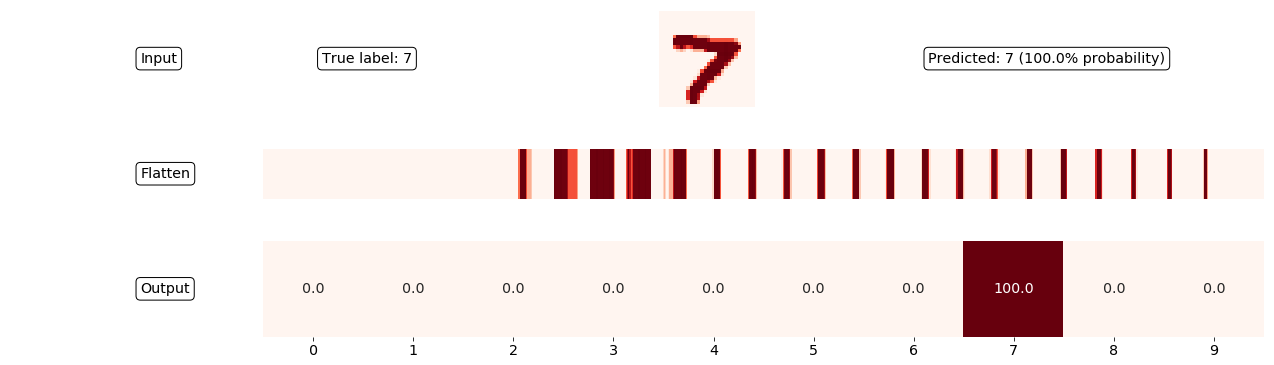

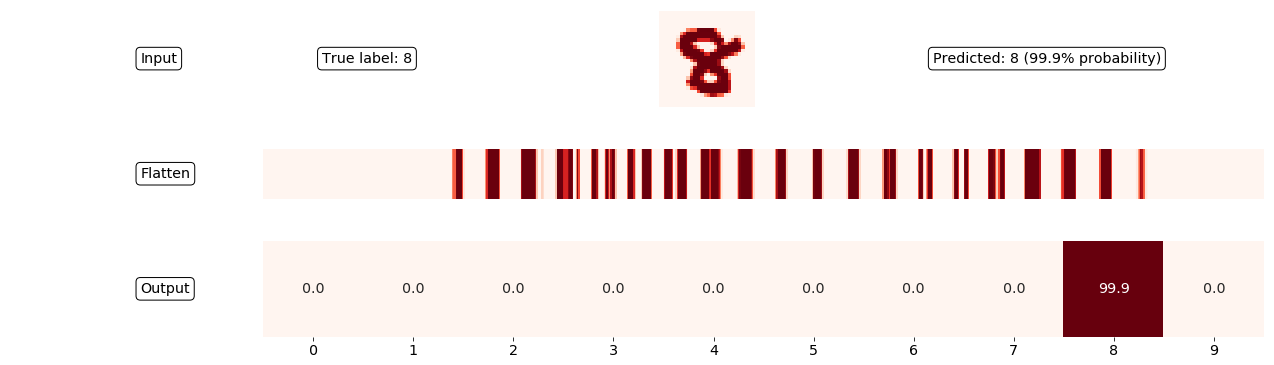

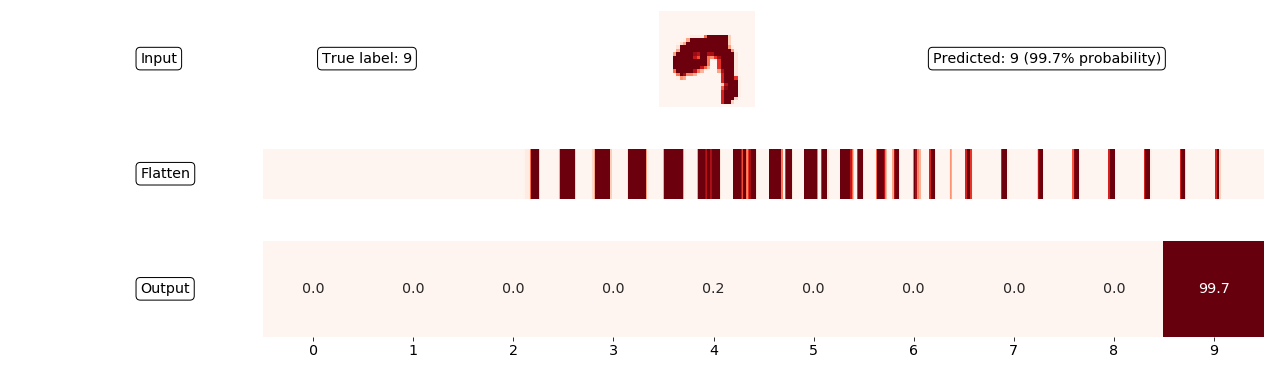

In [7]:
nvis.visualise_classbest()

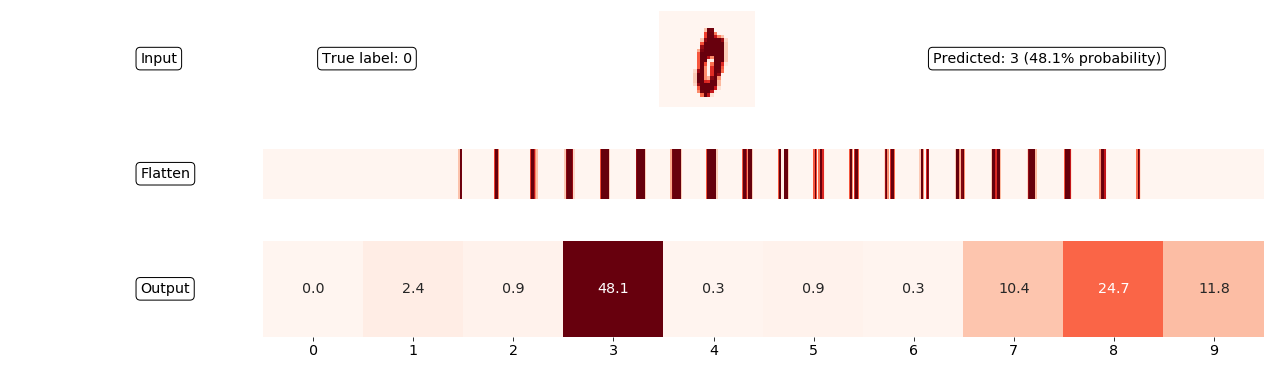

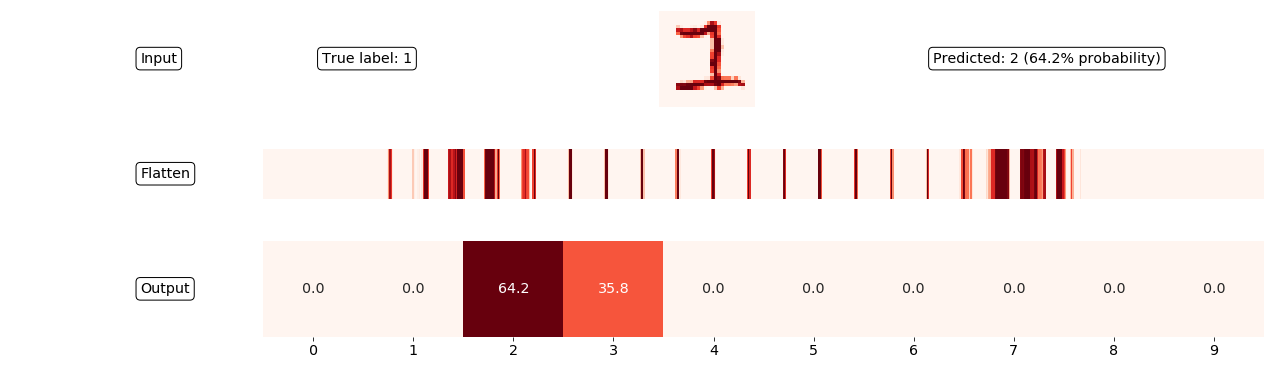

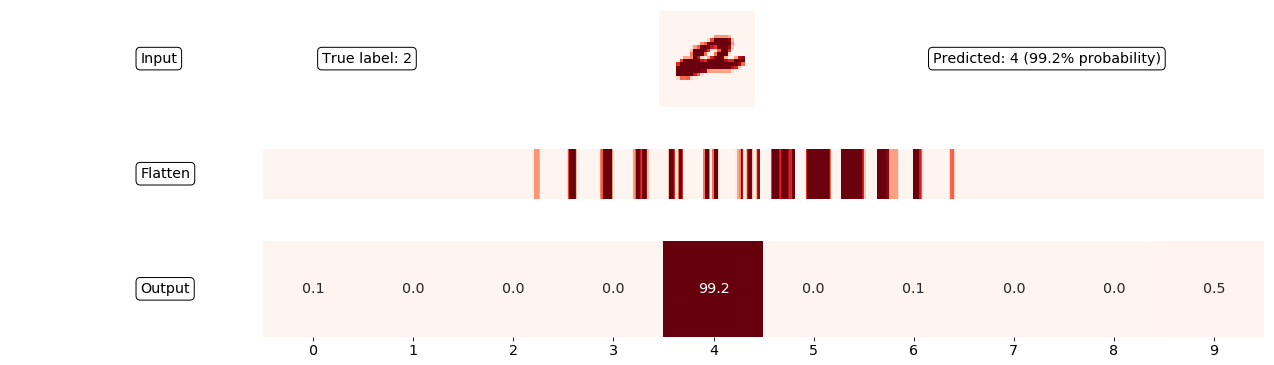

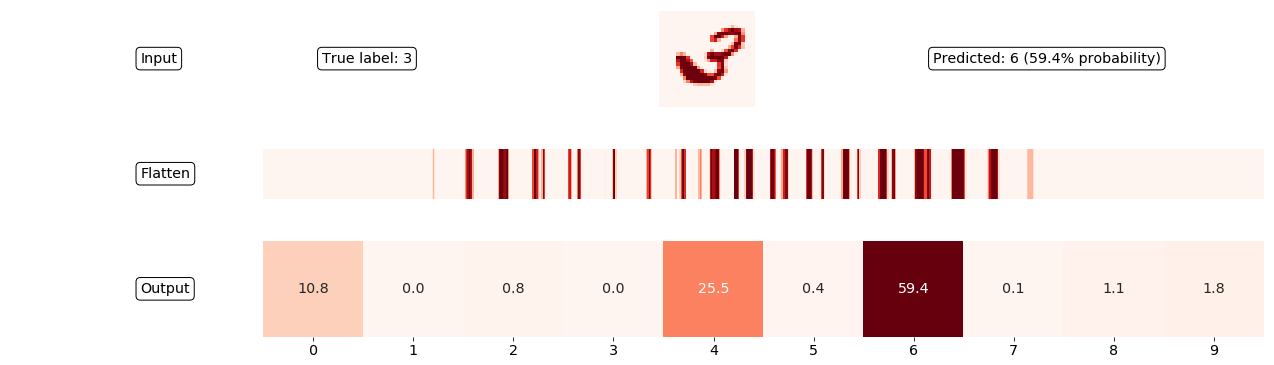

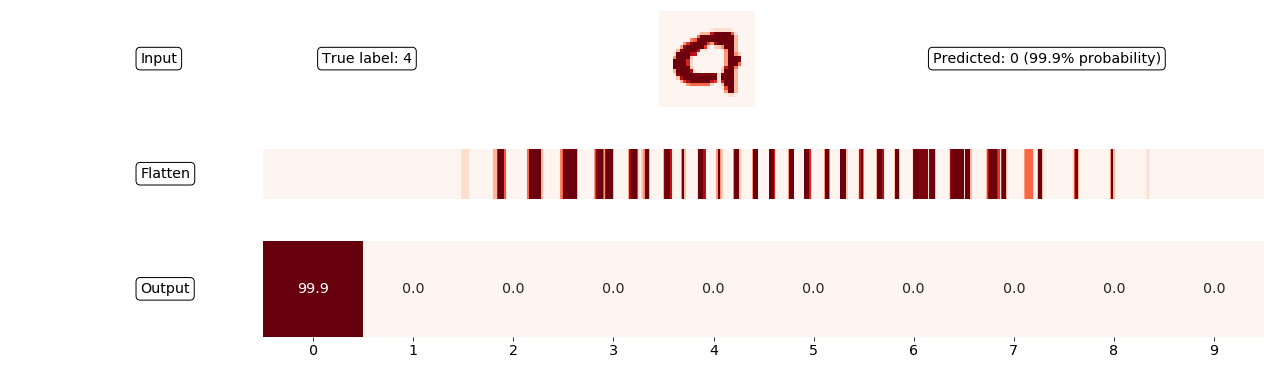

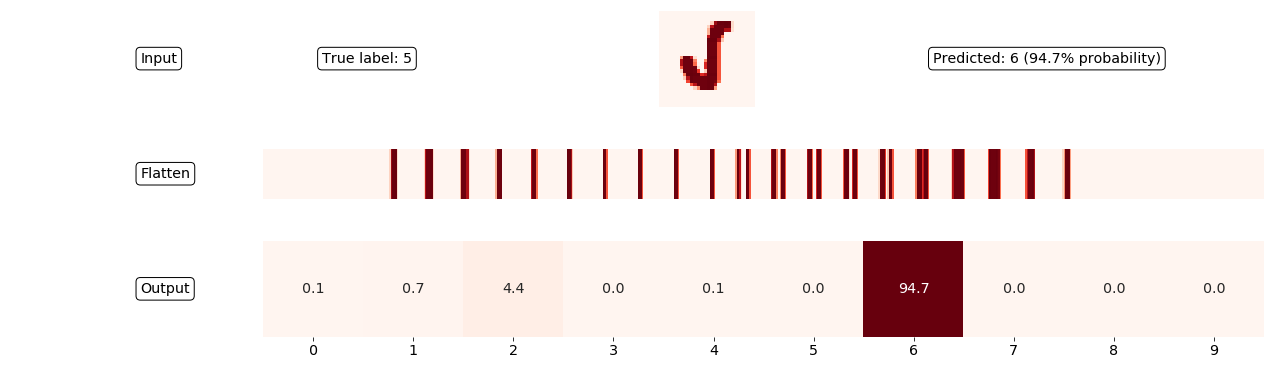

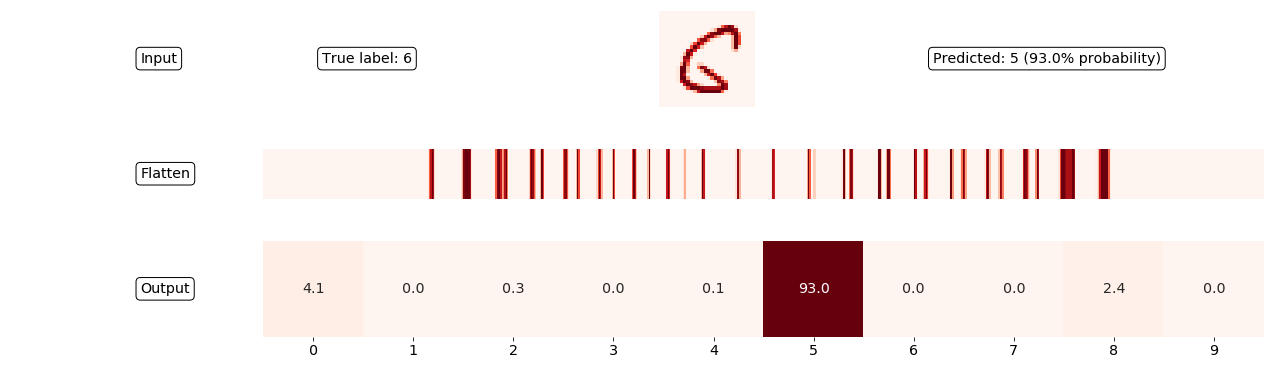

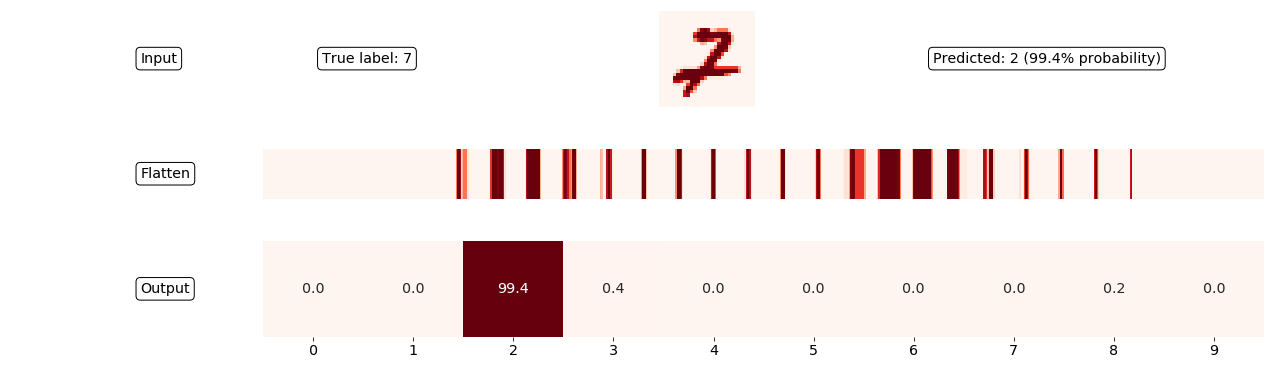

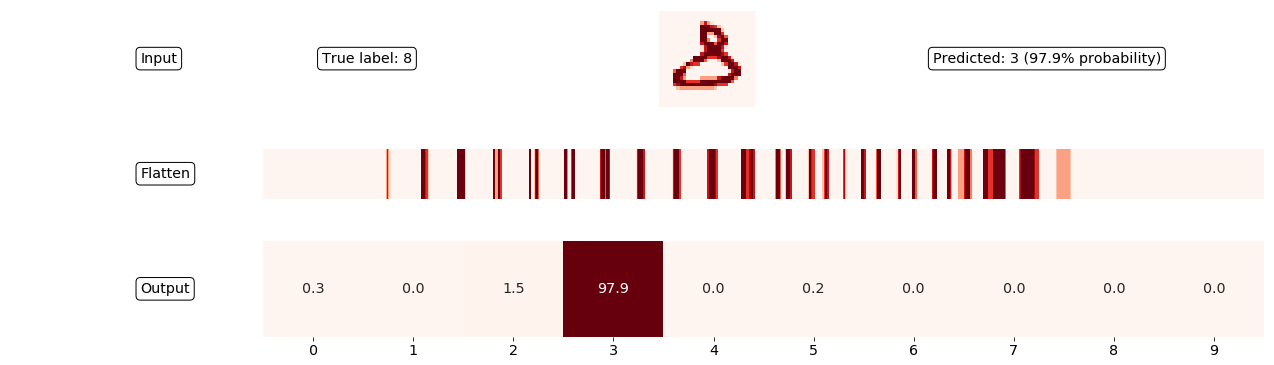

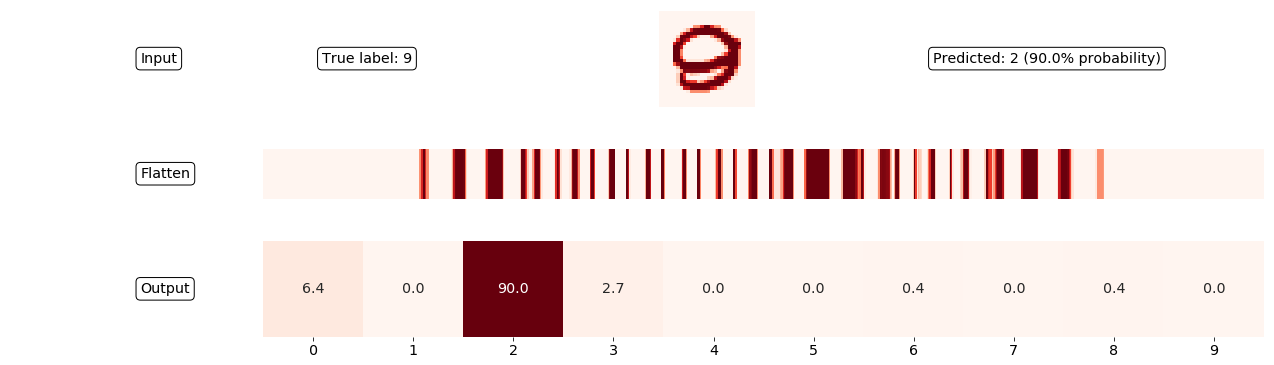

In [8]:
nvis.visualise_classworst()

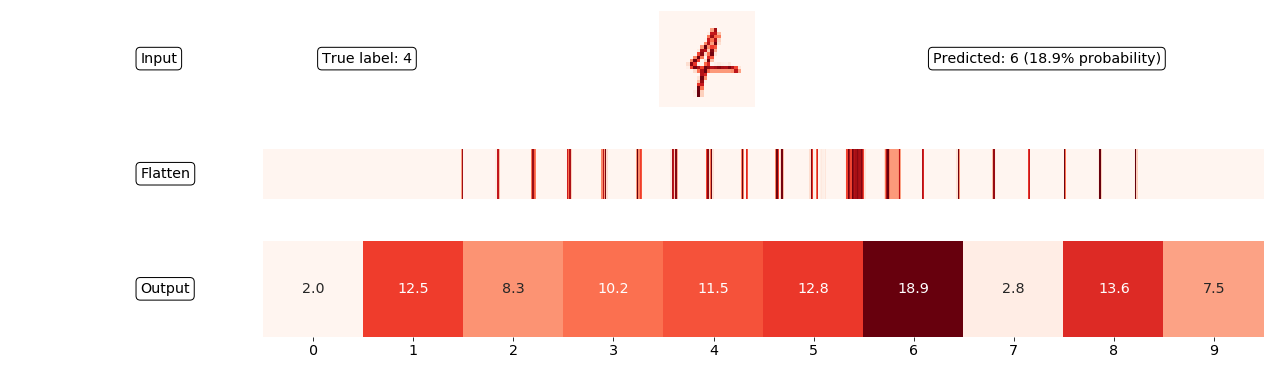

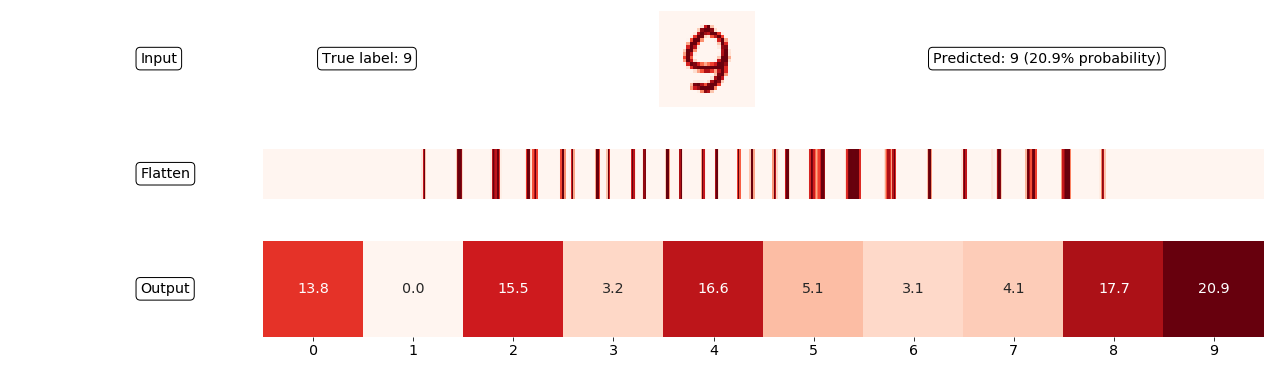

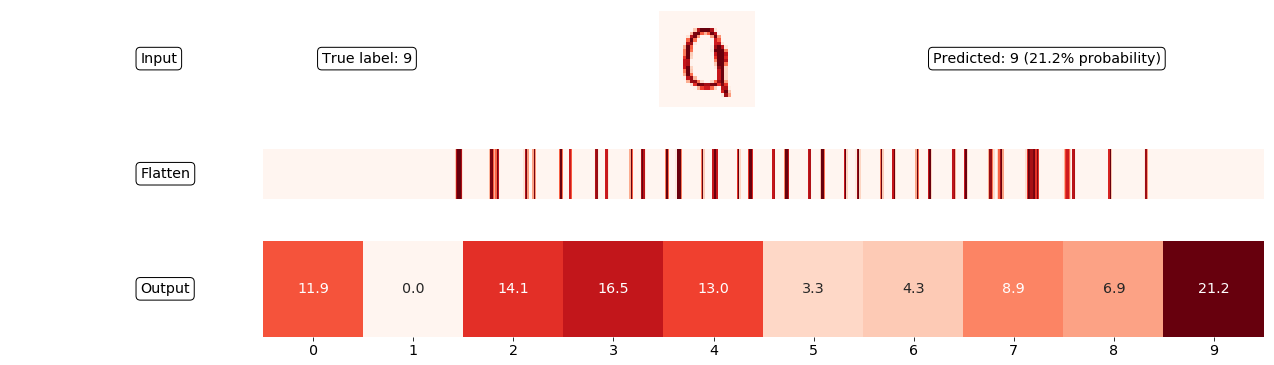

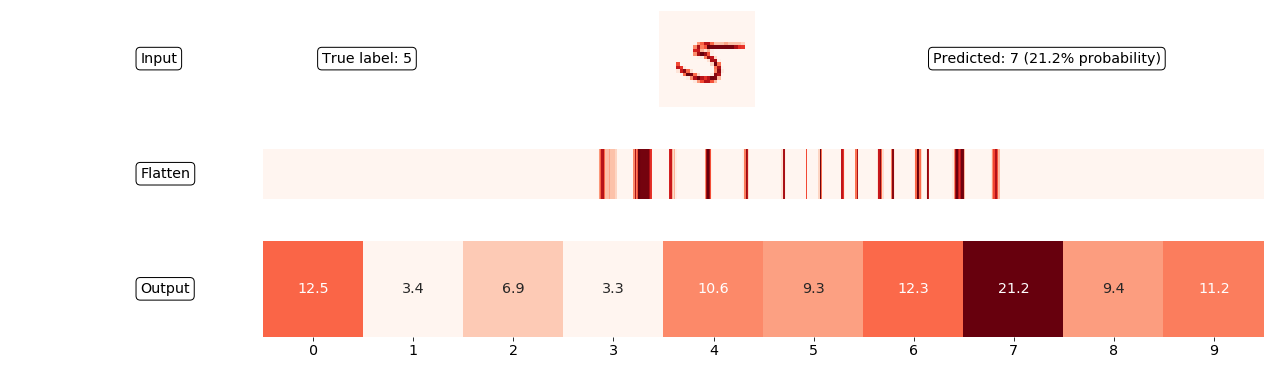

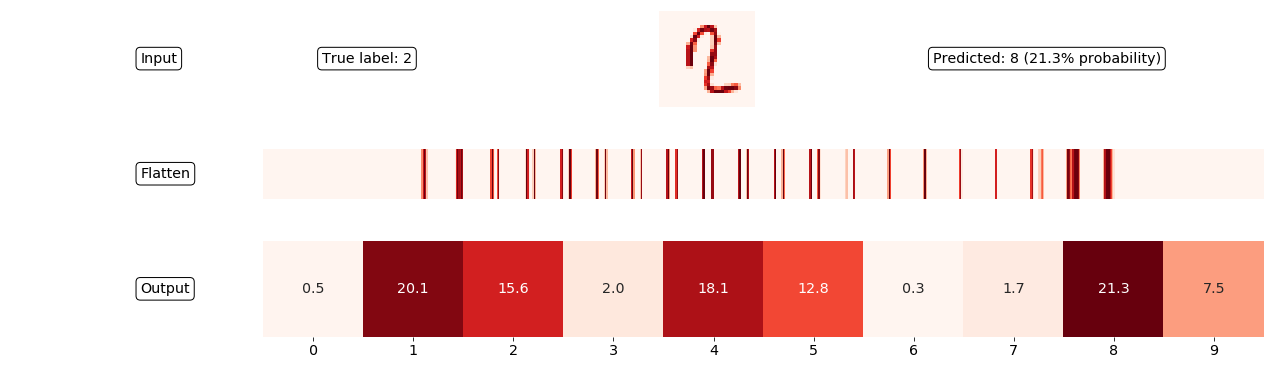

In [9]:
nvis.visualise_unsure()

<a id='oneconvol'></a>
## One Convolutional Layer

Loading data...
Shape of data file: (42000, 785)
Shape of network input: (42000, 28, 28, 1)
Shape of label vectors: (42000, 10)
First label vector: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 18s 523us/step - loss: 0.3750 - acc: 0.8979 - val_loss: 0.2166 - val_acc: 0.9337
Epoch 2/3
33600/33600 [==============================] - 18s 536us/step - loss: 0.1496 - acc: 0.9586 - val_loss: 0.1226 - val_acc: 0.9632
Epoch 3/3
33600/33600 [==============================] - 18s 523us/step - loss: 0.0969 - acc: 0.9729 - val_loss: 0.0900 - val_acc: 0.9719
Calculating output at each layer...
Conv layer has shape (42000, 24, 24, 12)
Flatten layer has shape (42000, 6912)
Output layer has shape (42000, 10)


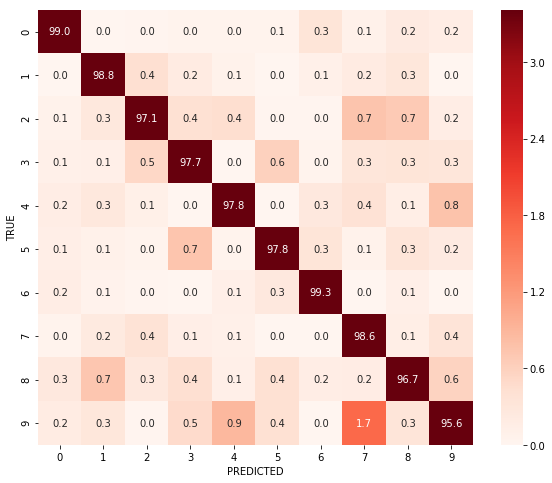

In [10]:
layers = [
          Conv2D(12, kernel_size=(5, 5), 
                      activation='relu',name='Conv',
                      input_shape=(img_rows, img_cols, 1)),
          Flatten(name='Flatten'),
          Dense(num_classes, activation='softmax',
                          name='Output')
        ]

nvis = NetworkVisualiser(layers)

nvis.fit(epochs=3)
nvis.show_conf_matrix()

Calculating TSNE representations...
Input...Conv...Flatten...Output...Done!


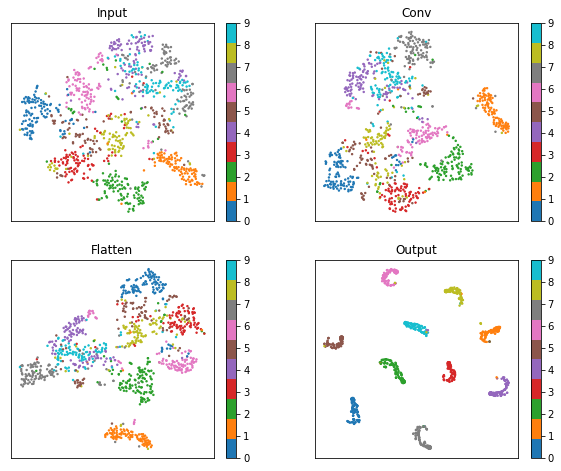

In [11]:
nvis.tsne_layers(range(1000))

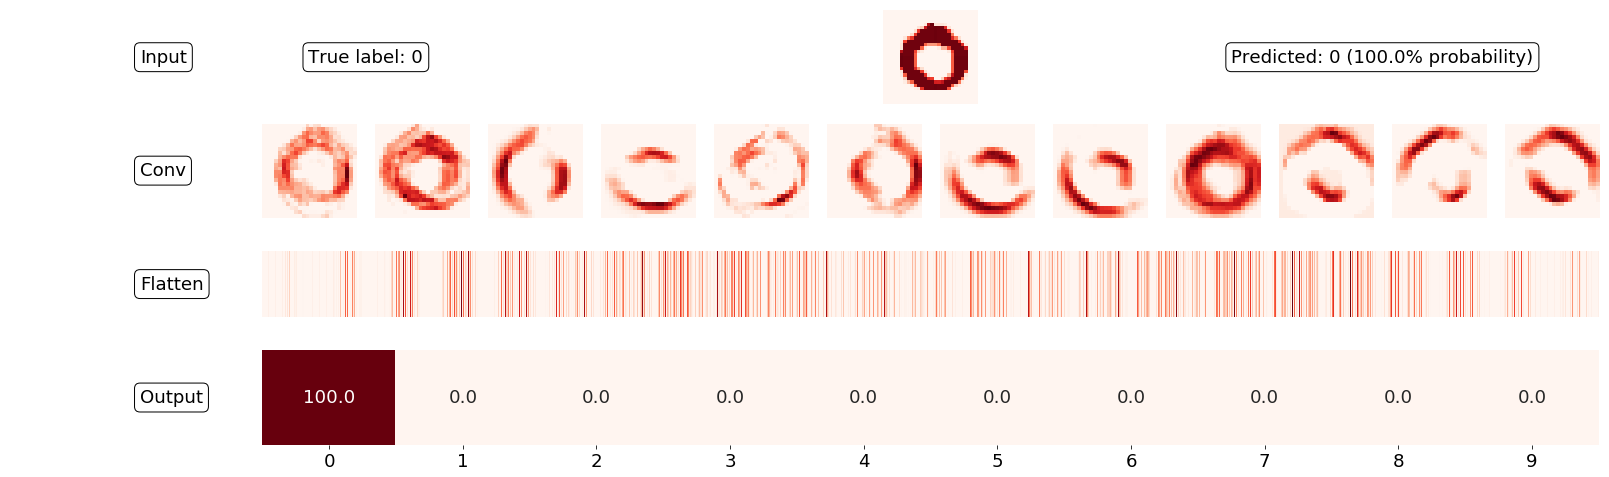

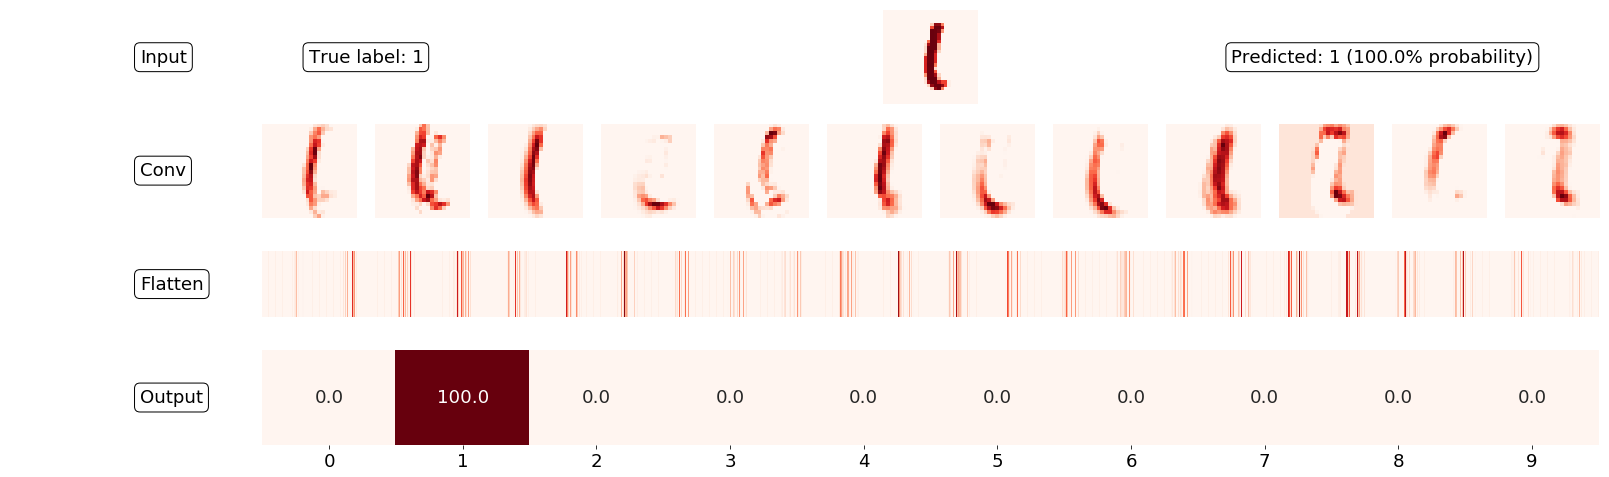

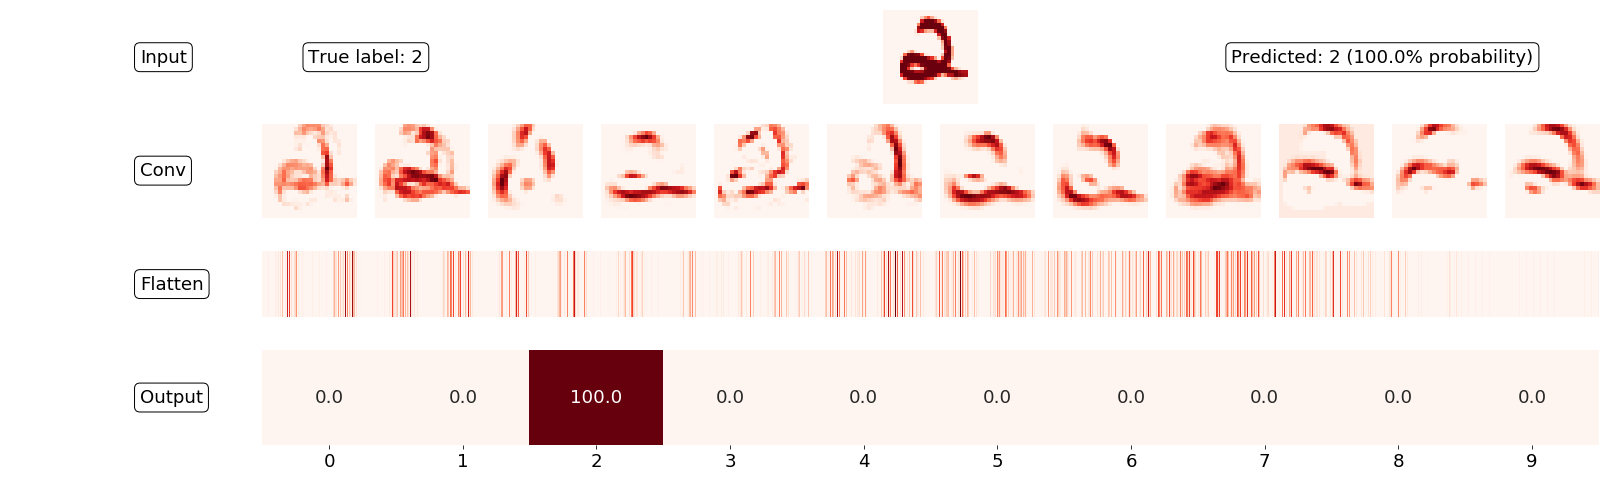

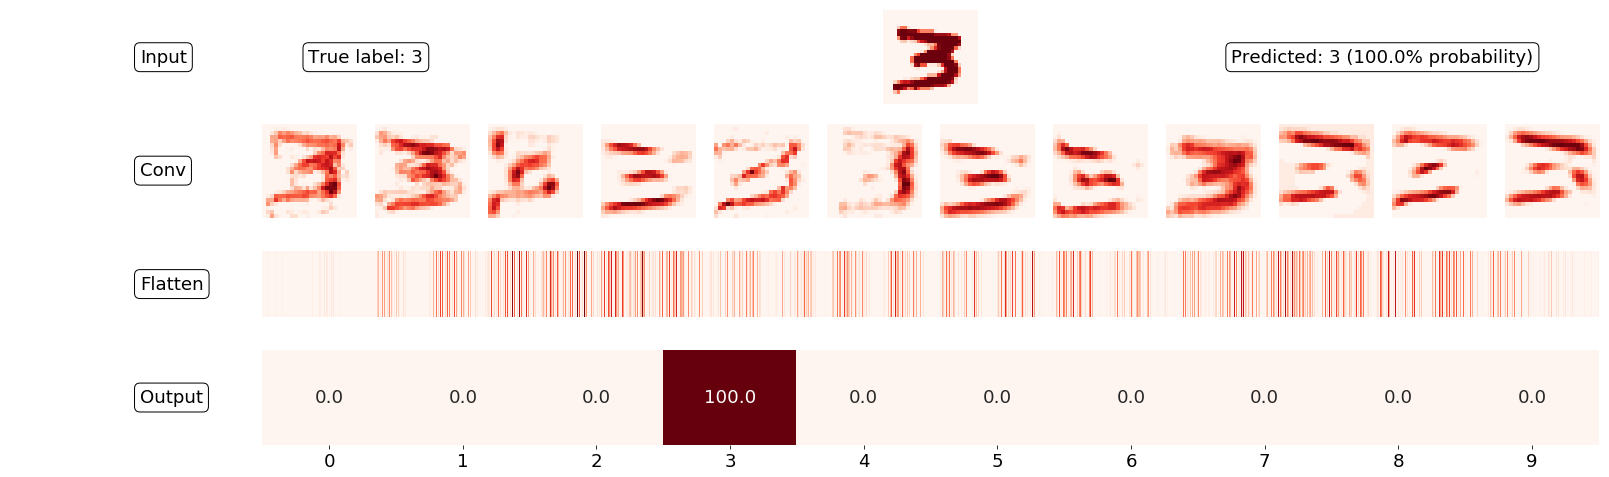

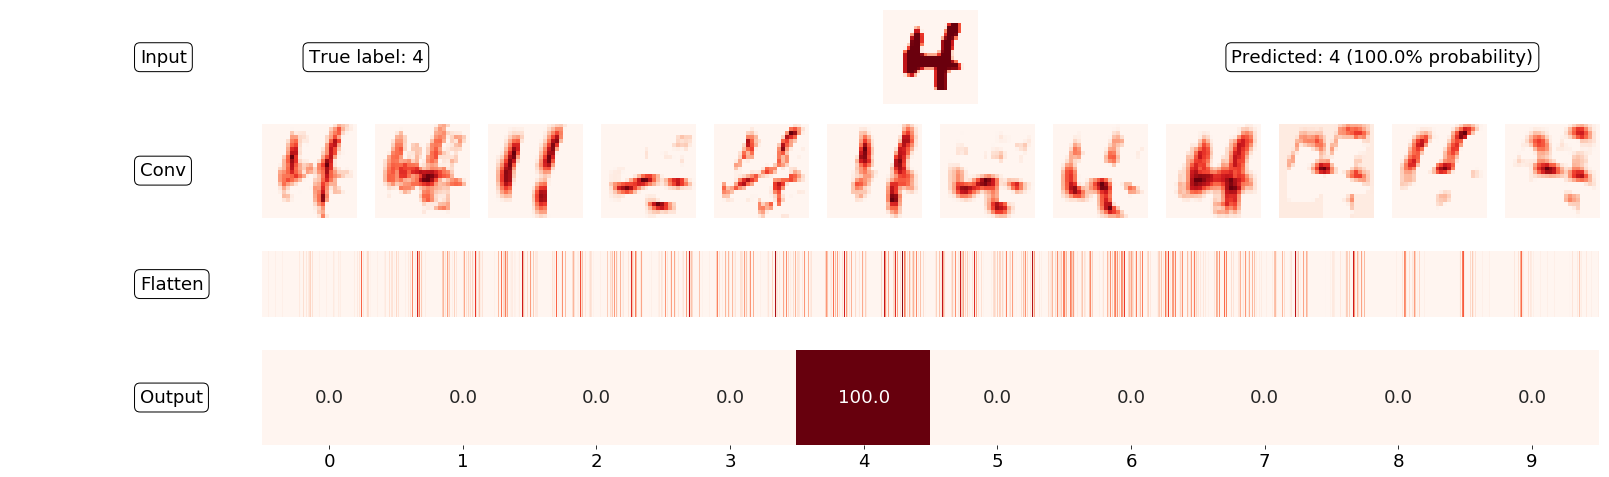

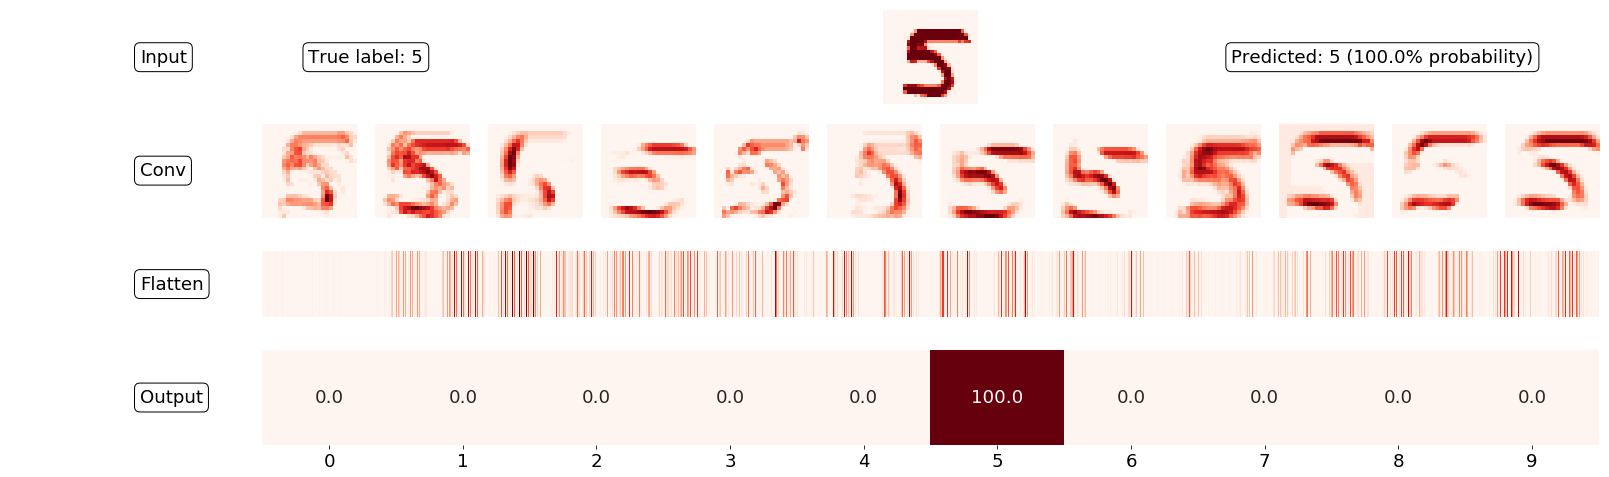

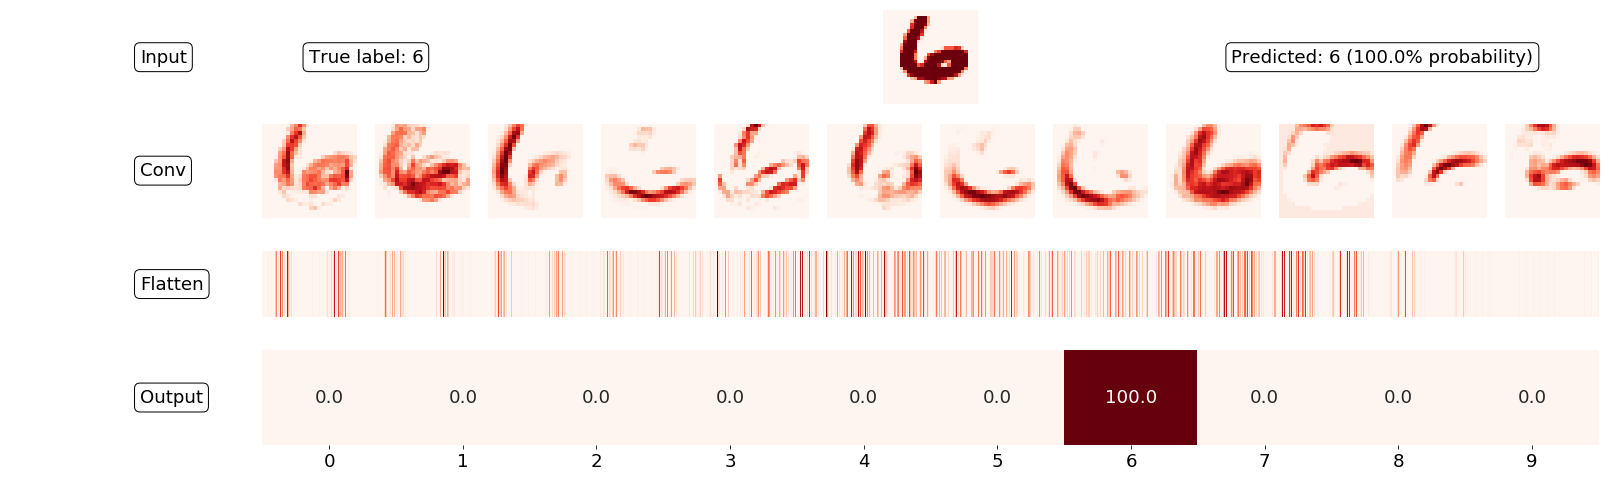

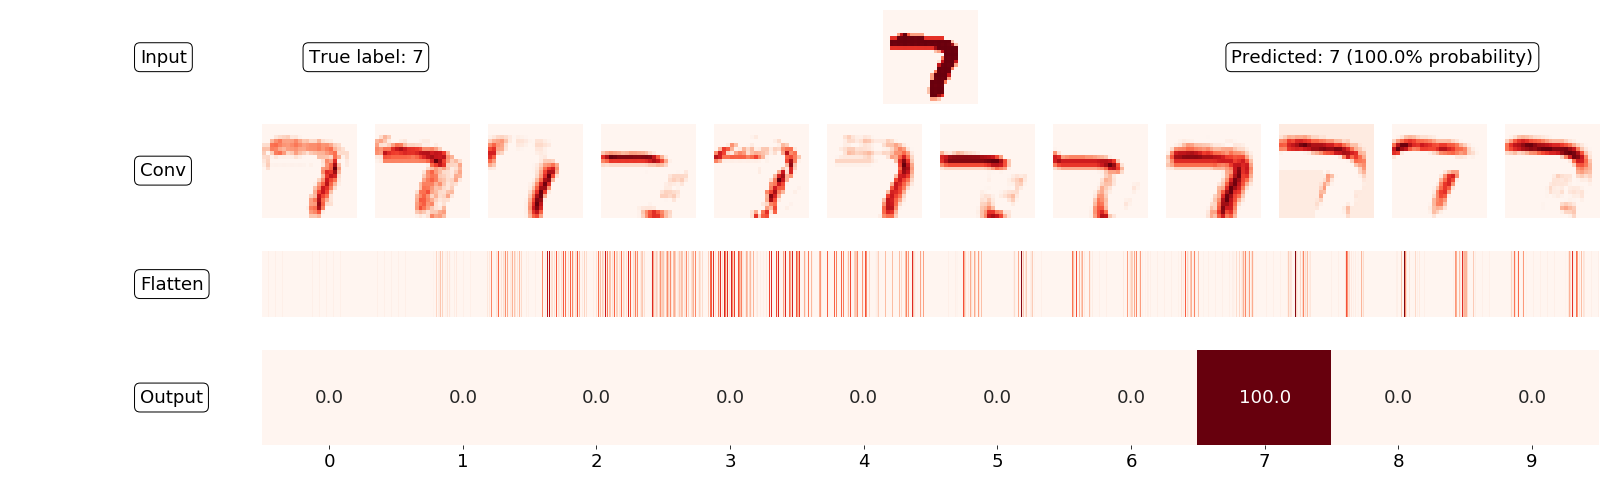

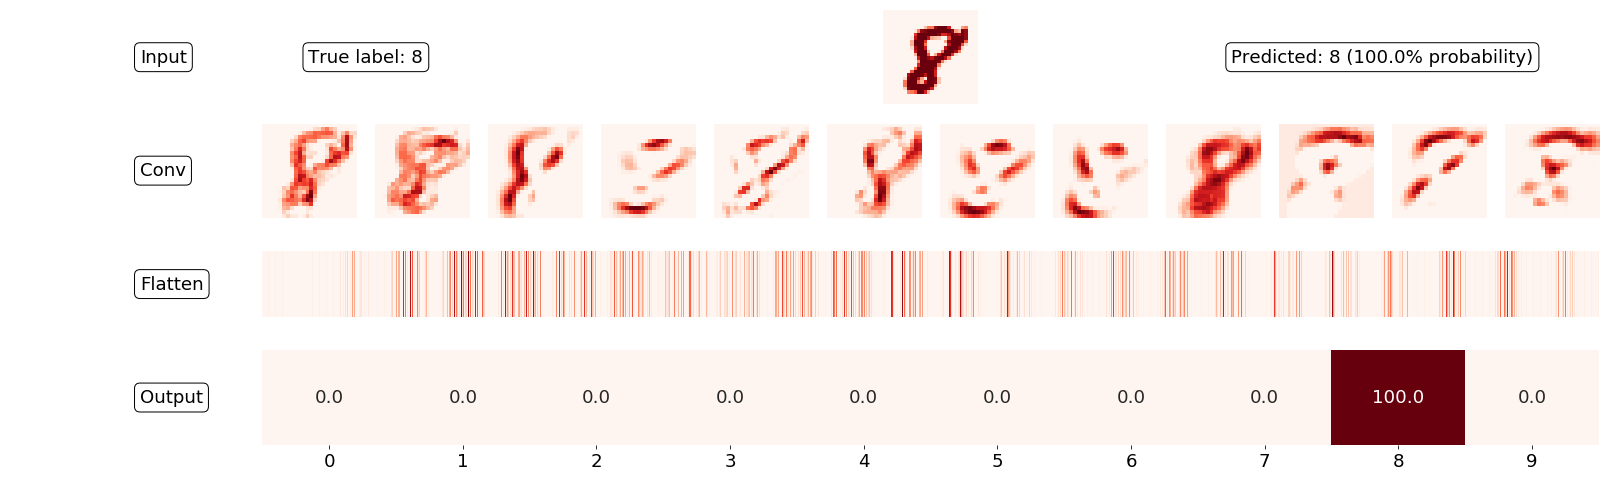

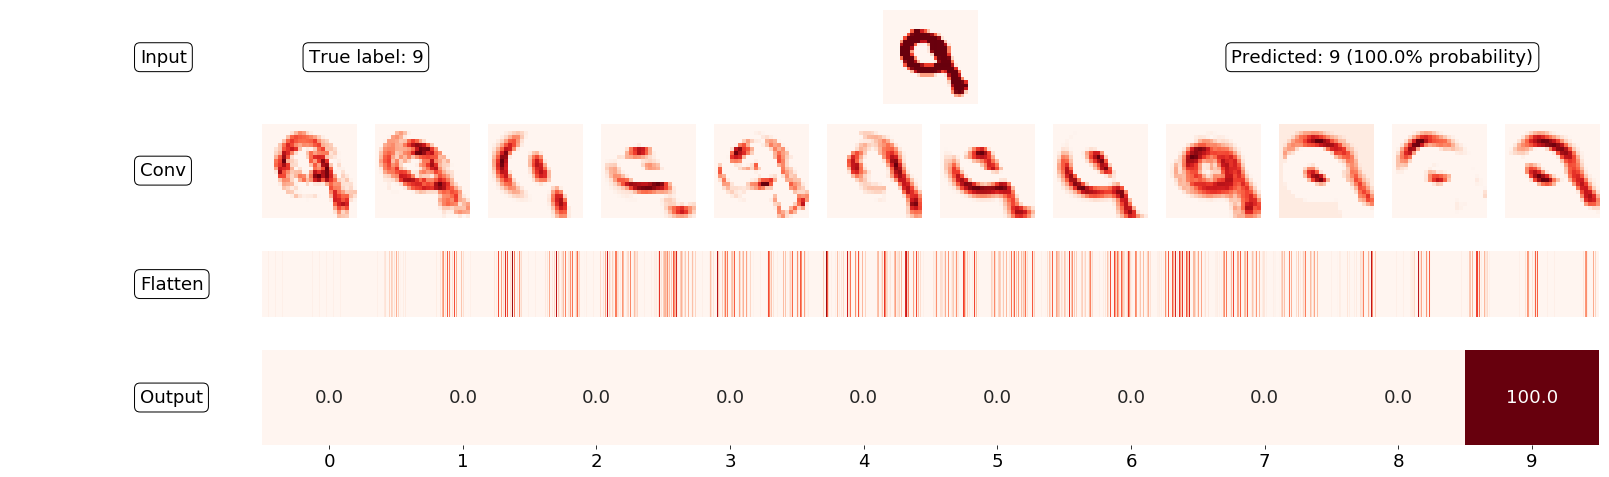

In [12]:
nvis.visualise_classbest()

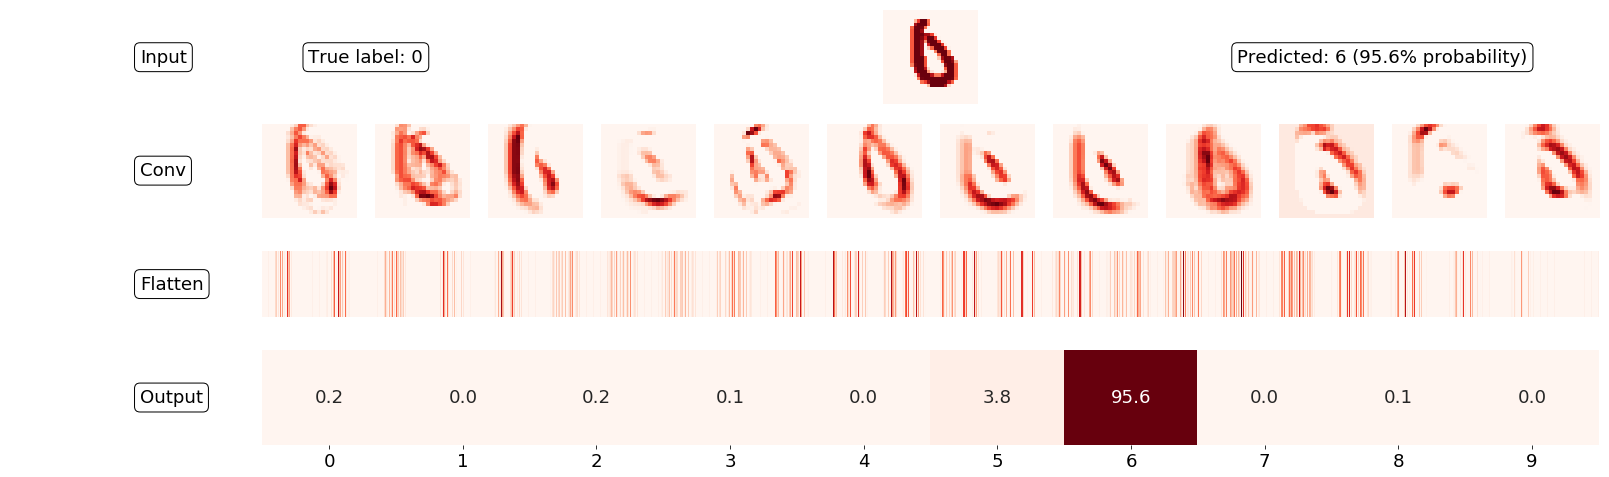

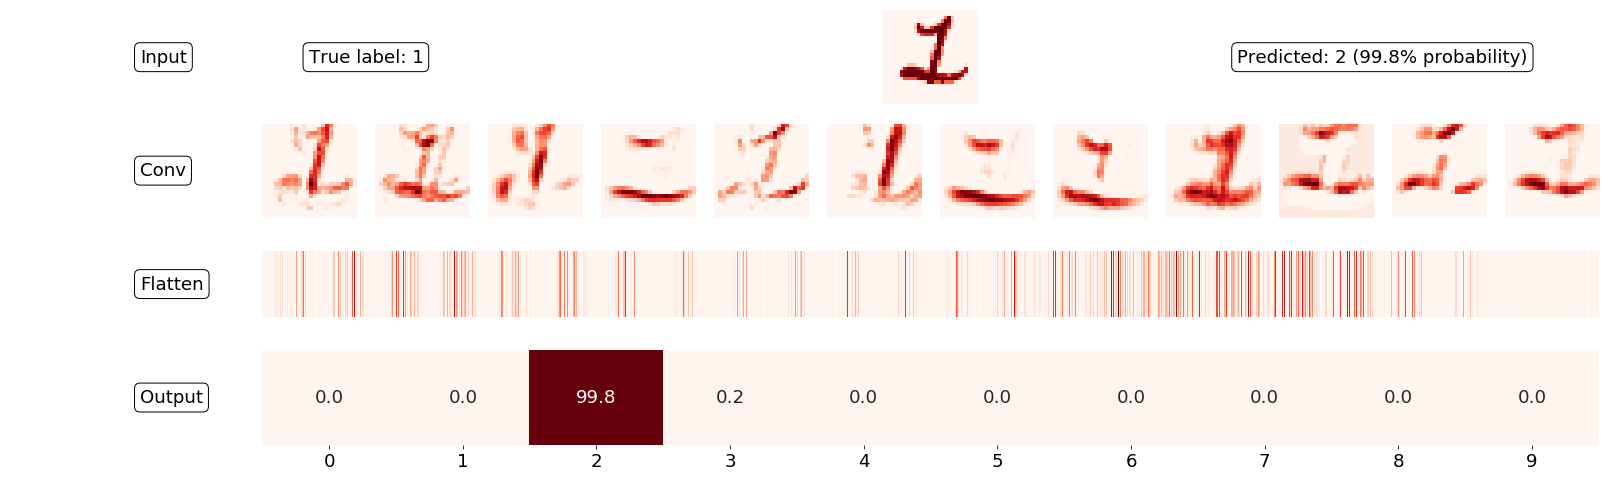

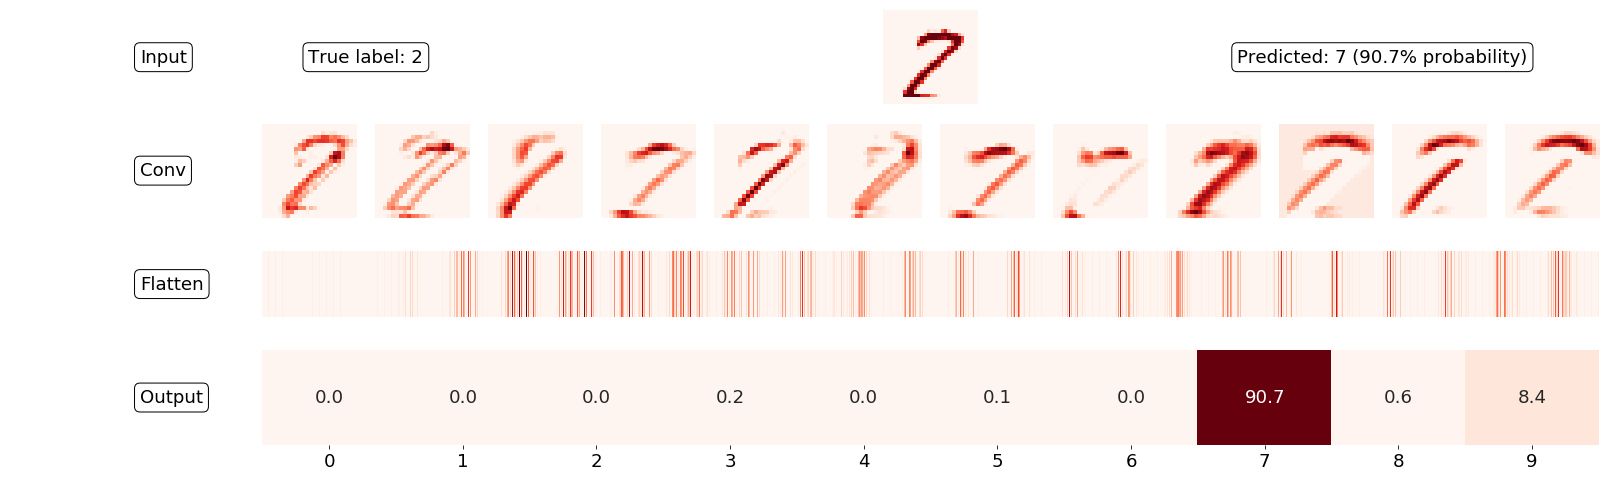

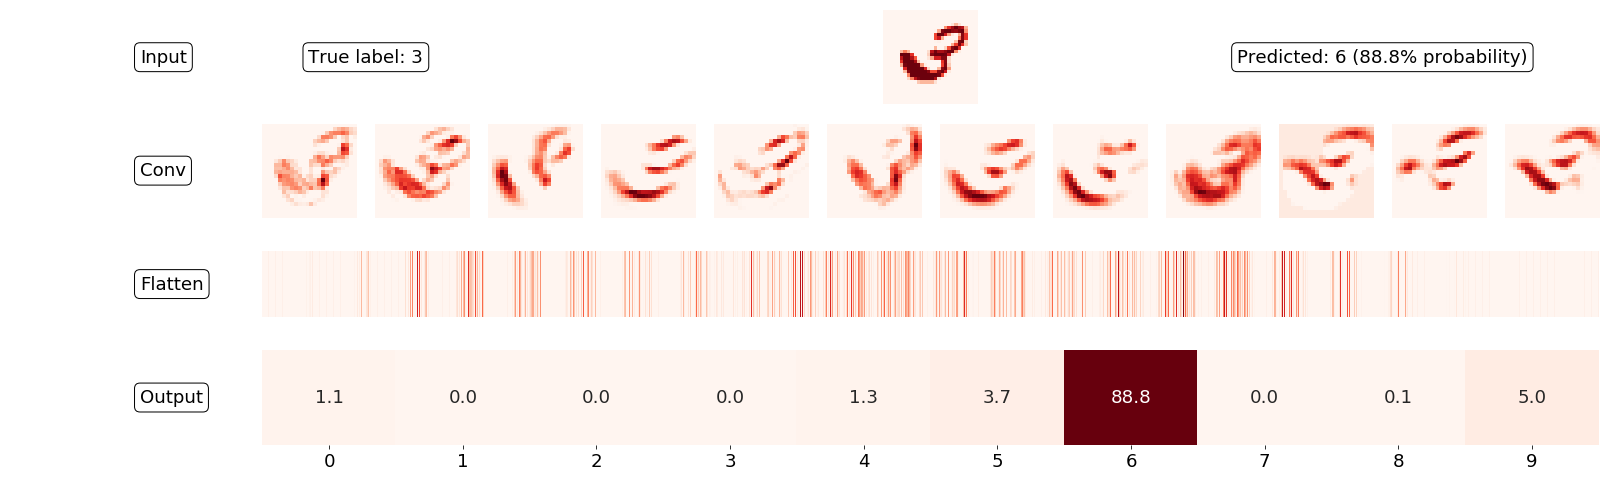

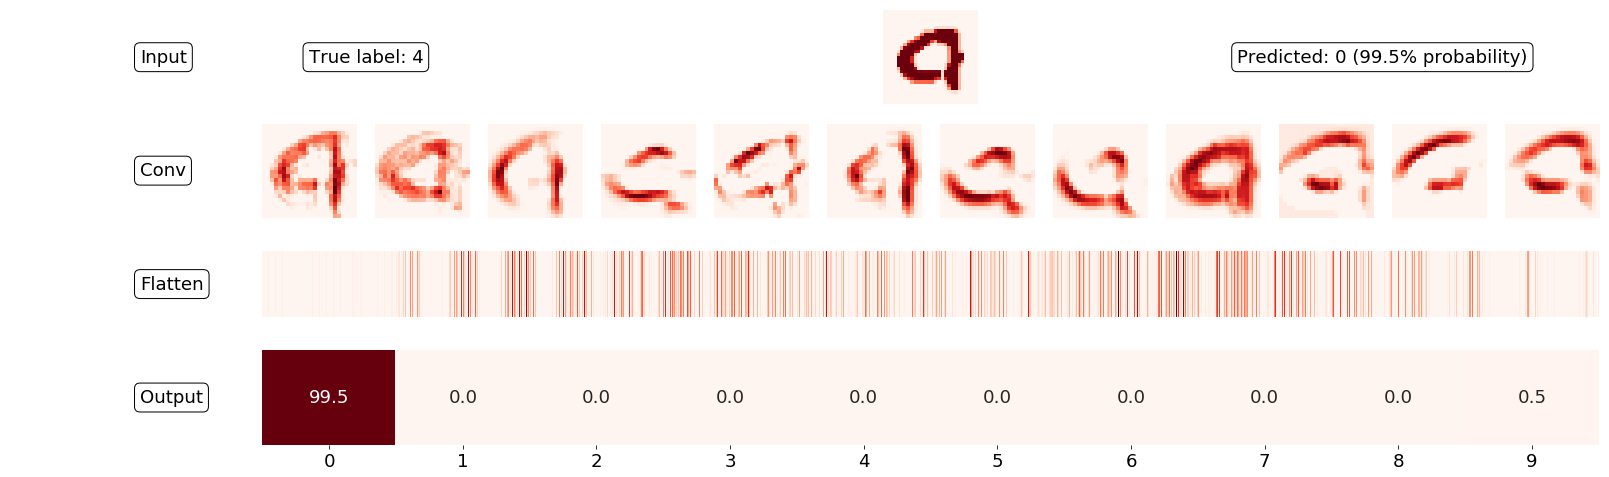

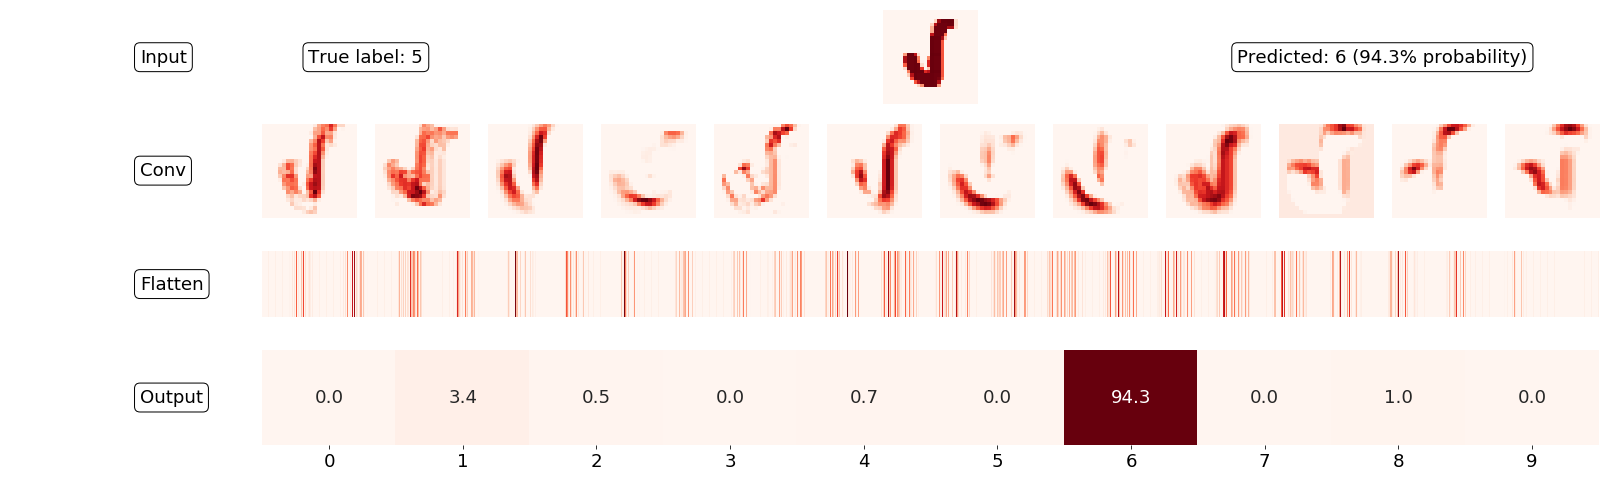

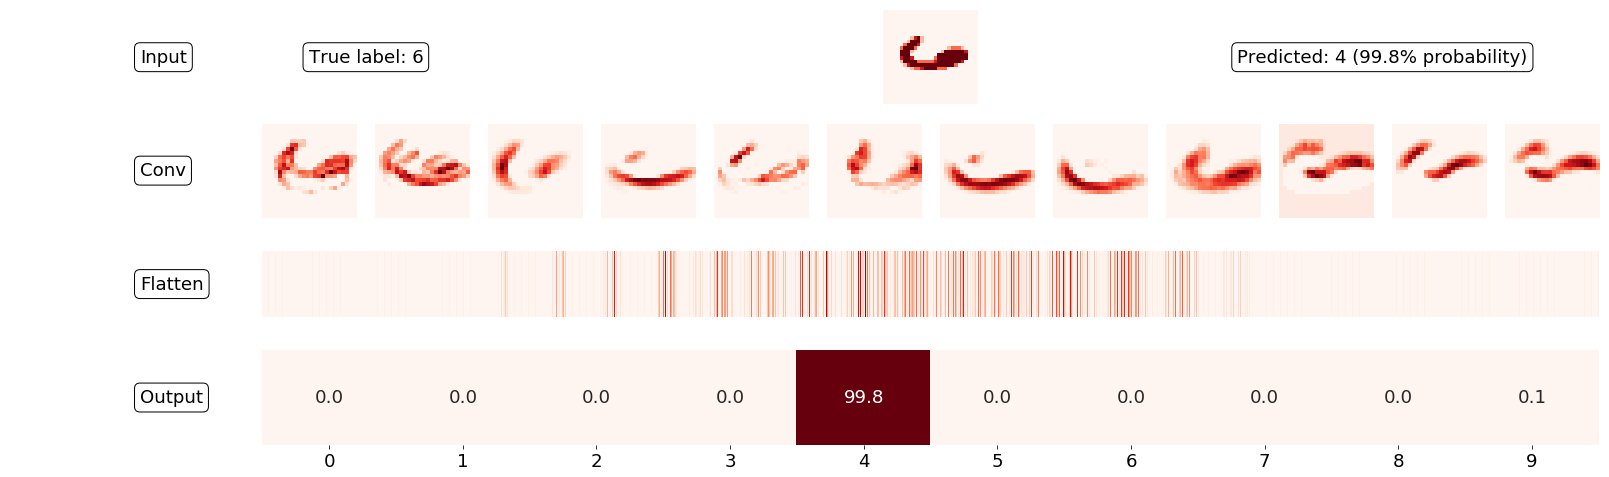

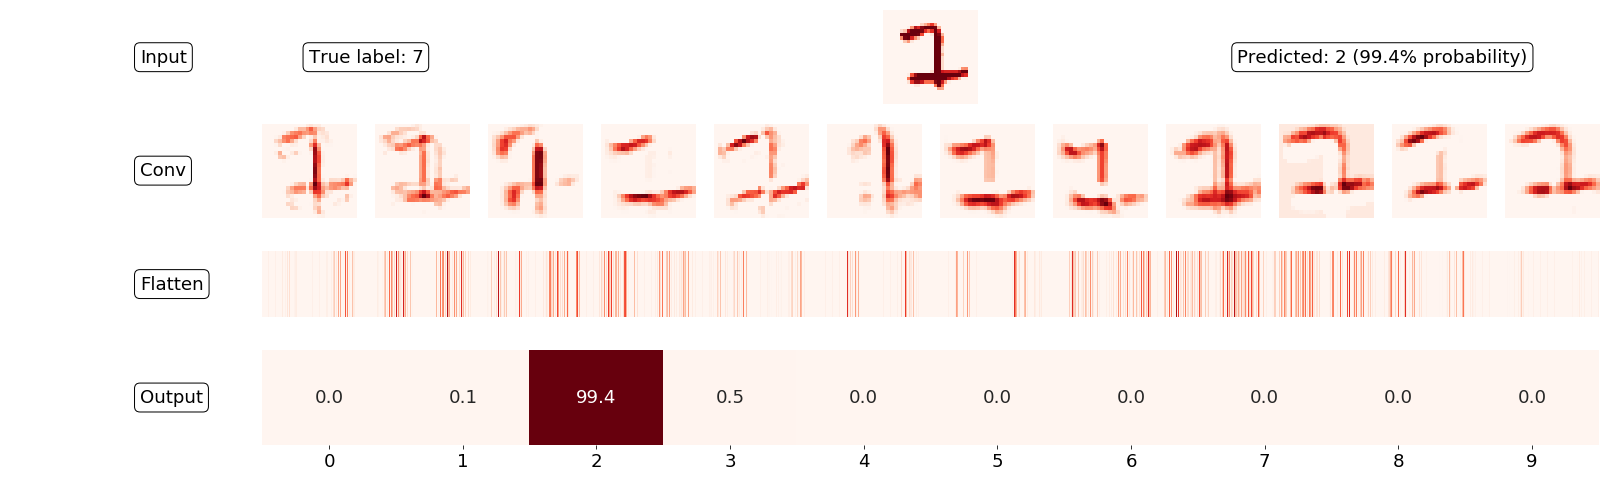

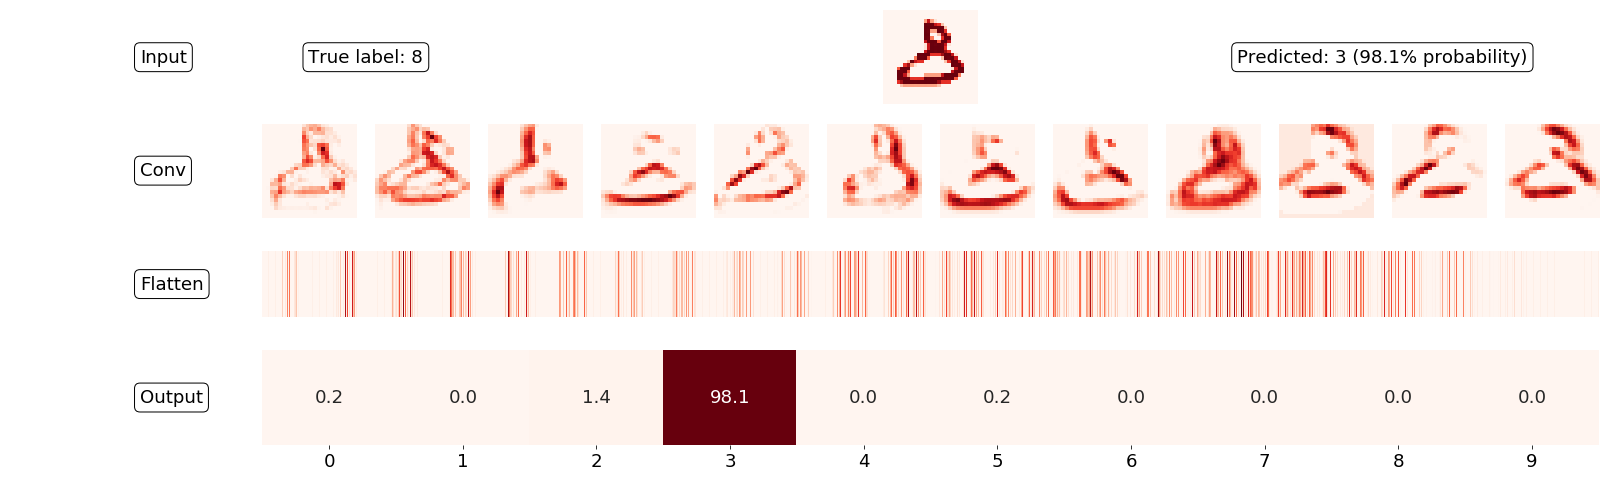

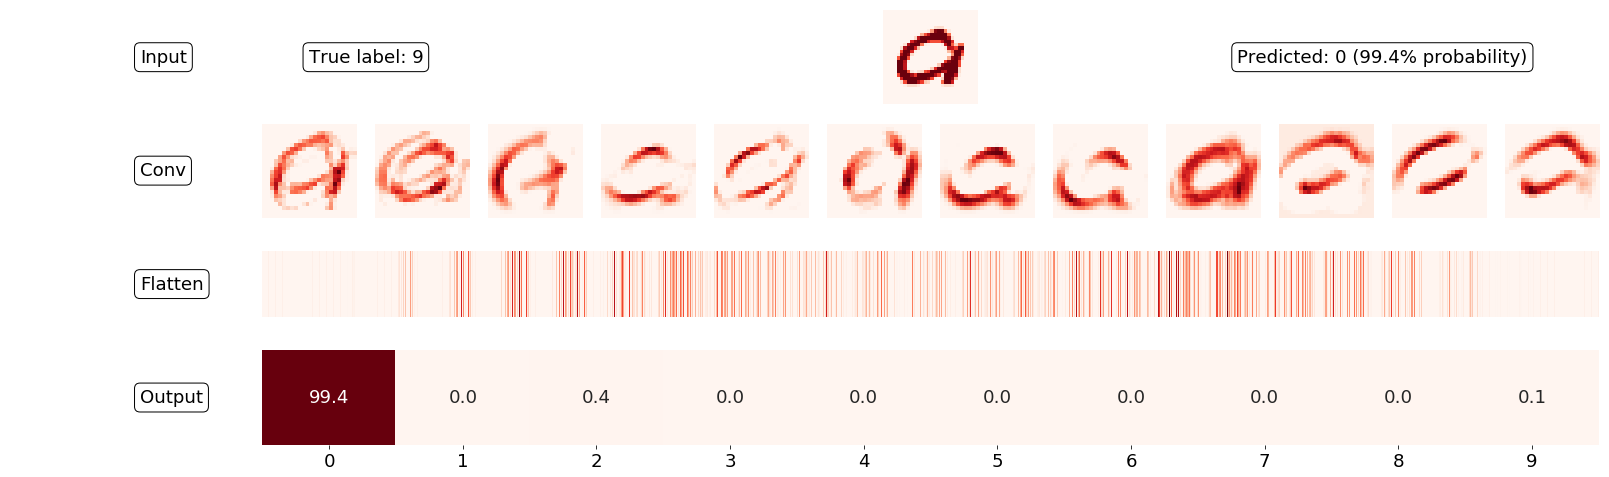

In [13]:
nvis.visualise_classworst()

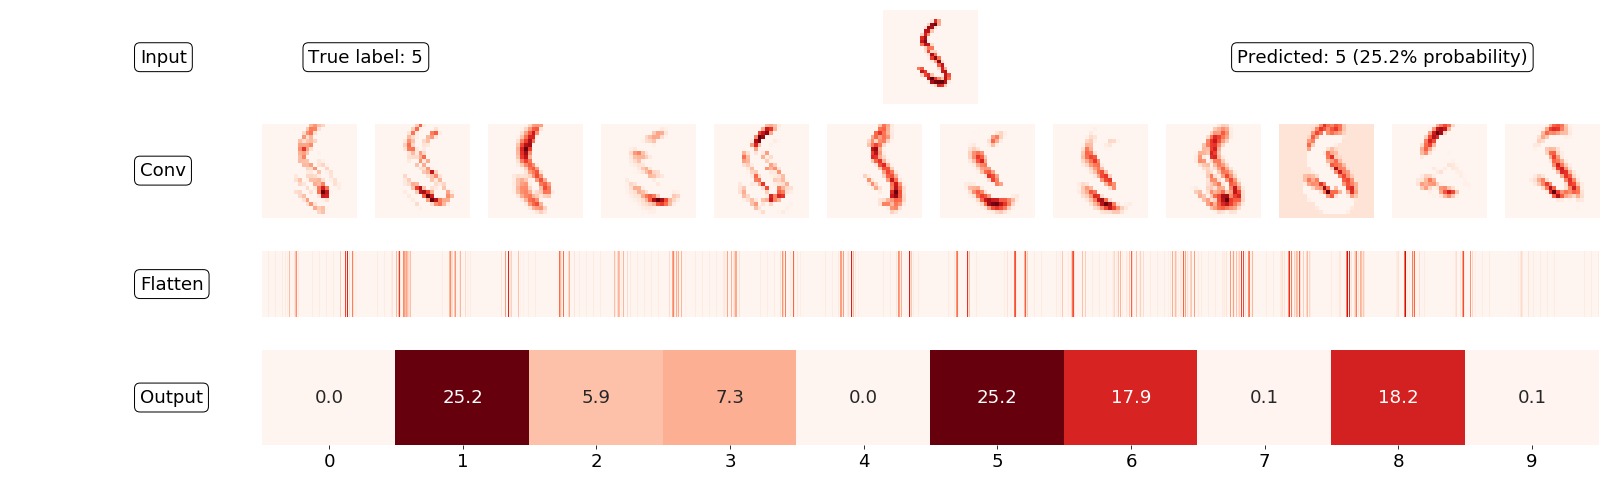

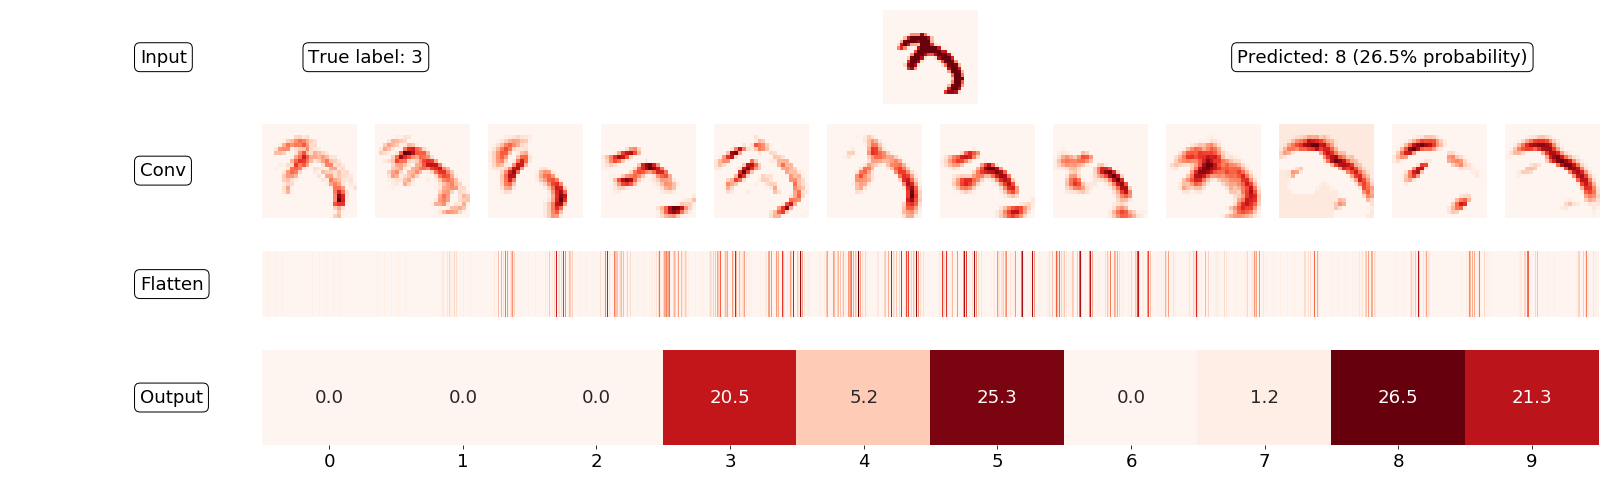

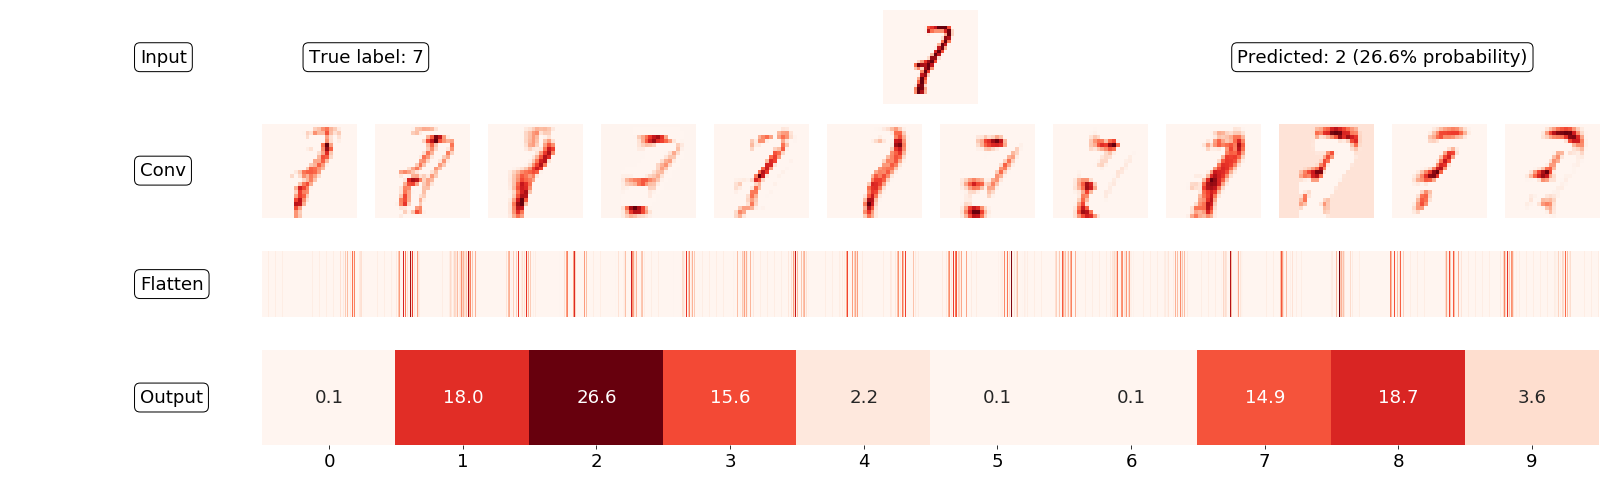

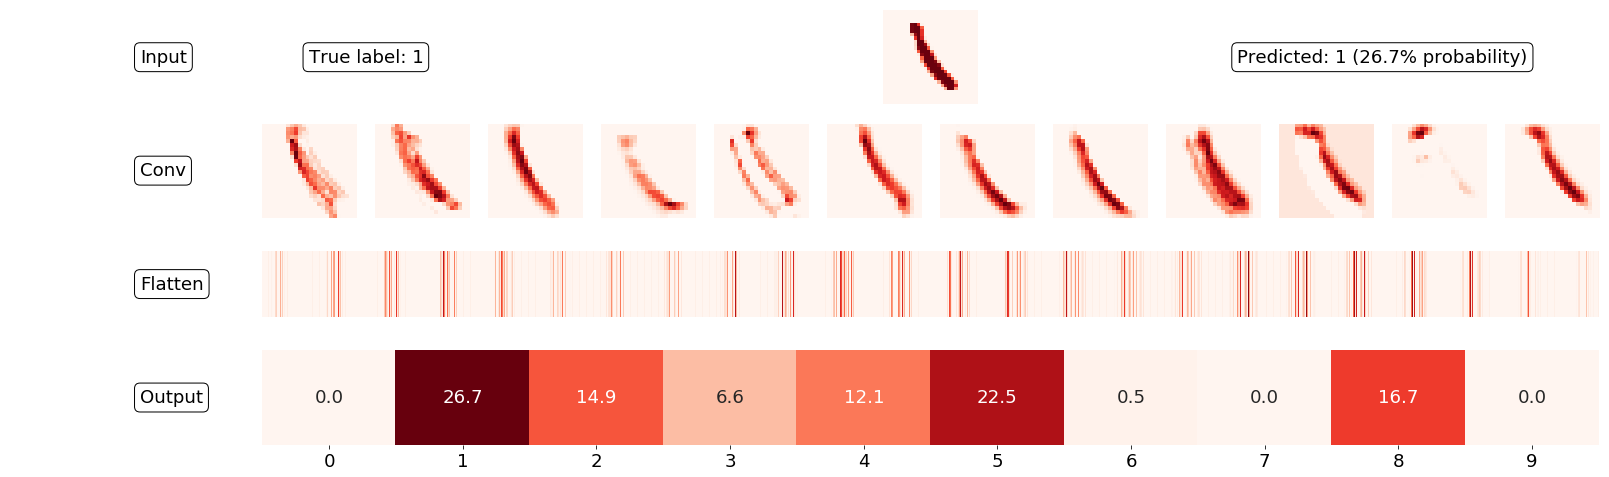

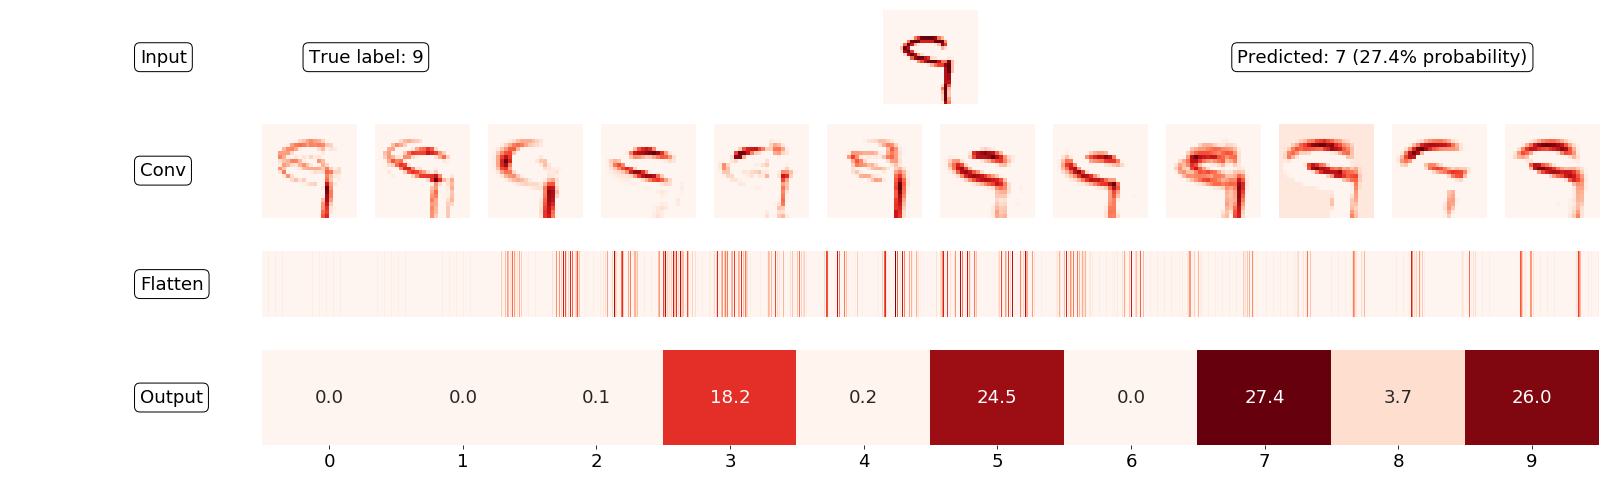

In [14]:
nvis.visualise_unsure()

<a id='multiconvol'></a>
## Multiple

In [15]:
# Define layers to include in the network
# recommend giving each layer a meaningful name
# output should always be dense with num_classes nodes
layers = [
          Conv2D(10, kernel_size=(5, 5), 
                          activation='relu',name='Conv1',
                          input_shape=(img_rows, img_cols, 1)),
          Conv2D(15, kernel_size=(5, 5), 
                          activation='relu',name='Conv2'),
          Conv2D(20, kernel_size=(3, 3), 
                          activation='relu',name='Conv3'),  
          Conv2D(25, kernel_size=(3, 3), 
                          activation='relu',name='Conv4'),    
          MaxPool2D(pool_size=(2, 2), strides=2,
                          name='Pool1'),
          Flatten(name='Flatten'),
          Dense(50, activation='relu',name='Dense1'),   
          Dense(num_classes, activation='softmax',
                          name='Output')
        ]

nvis = NetworkVisualiser(layers, data_file=data_file, label_col=label_col, 
                         num_classes=num_classes, img_rows=img_rows, img_cols=img_cols)

Loading data...
Shape of data file: (42000, 785)
Shape of network input: (42000, 28, 28, 1)
Shape of label vectors: (42000, 10)
First label vector: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 118s 4ms/step - loss: 0.3019 - acc: 0.9058 - val_loss: 0.0869 - val_acc: 0.9763
Epoch 2/3
33600/33600 [==============================] - 131s 4ms/step - loss: 0.0747 - acc: 0.9773 - val_loss: 0.0707 - val_acc: 0.9789
Epoch 3/3
33600/33600 [==============================] - 114s 3ms/step - loss: 0.0528 - acc: 0.9842 - val_loss: 0.0586 - val_acc: 0.9806
Calculating output at each layer...
Conv1 layer has shape (42000, 24, 24, 10)
Conv2 layer has shape (42000, 20, 20, 15)
Conv3 layer has shape (42000, 18, 18, 20)
Conv4 layer has shape (42000, 16, 16, 25)
Pool1 layer has shape (42000, 8, 8, 25)
Flatten layer has shape (42000, 1600)
Dense1 layer has shape (42000, 50)
Output layer has shape (42000, 10)


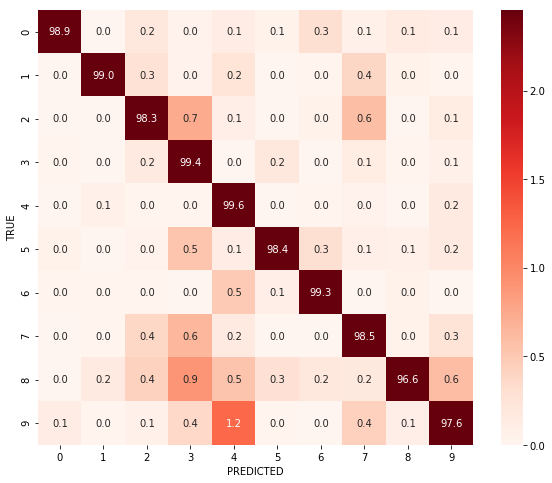

In [16]:
nvis.fit(epochs=3)
nvis.show_conf_matrix()

In [17]:
nvis.tsne_layers(range(1000))

Calculating TSNE representations...
Input...

KeyboardInterrupt: 

In [ ]:
nvis.visualise_classbest()

In [ ]:
nvis.visualise_classworst()

In [ ]:
nvis.visualise_unsure()
plt.savefig('unsure9.png')